In [ ]:
from choreo_k.movenet_detector import Detector
#from choreo_k.pifpafpose_detector import Detector
from choreo_k.modify import interpolate_missing_poses, trim_empty_frames_start_end, zeroify_detections_y_first, get_figure_coords_y_first
from choreo_k.matrixify import get_normalized_coords, compare_poses_cosine, normalize_and_compare_poses_cosine, symmetrify_pose, normalize_pose, normalize_symmetrify_and_compare_poses_cosine
from choreo_k.analyze import correlate_time_series

import pickle

#%matplotlib inline

In [ ]:
import logging
import numpy as np
import os
from pathlib import Path

import cv2
import librosa
import librosa.display
import matplotlib.pyplot as plt
import PIL
from PIL import ImageDraw # This needs to be imported separately
from scipy.interpolate import interp1d
import statistics

logging.basicConfig(level=logging.INFO, format="%(message)s")

In [ ]:
hop_length = 1024

def __progress__(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def get_audio_timeseries(audio_filepath):
    if Path(audio_filepath.replace(".mp3", ".p")).exists():
        y, fs = pickle.load(open(audio_filepath.replace(".mp3", ".p"), "rb"))
    else:
        y, fs = librosa.load(audio_filepath)  # , sr=None)
        pickle.dump([y, fs], open(audio_filepath.replace(".mp3", "_audio.p"), "wb"))
    return [y, fs]

def get_spectrogram_features(audio_filepath, hop_length):

    y, fs = get_audio_timeseries(audio_filepath)

    duration = librosa.get_duration(y)

    total_samples = y.size

    sgram = librosa.feature.melspectrogram(y=y, sr=fs, hop_length=hop_length)

    return [sgram, fs, duration, total_samples]

def get_chroma_features(audio_filepath, hop_length):

    y, fs = get_audio_timeseries(audio_filepath)

    duration = librosa.get_duration(y)

    total_samples = y.size

    chroma = librosa.feature.chroma_stft(y=y, sr=fs, hop_length=hop_length)

    return [chroma, fs, duration, total_samples]

def match_audio_excerpt_to_full(full, excerpt):
    scores = []
    if len(full.shape) == 1:
        full_length = len(full)
        excerpt_length = len(excerpt)
        stride_length = hop_length
    else:
        full_length = full.shape[1]
        excerpt_length = excerpt.shape[1]
        stride_length = 1 # hop_length has already been applied

    for left_index in range(0, full_length, stride_length):

        if len(full.shape) == 1:
            full_section = full[left_index : min(full_length, left_index + excerpt_length)]
            full_section_length = len(full_section)
        else:
            full_section = full[
                :, left_index : min(full_length, left_index + excerpt_length)
            ]
            full_section_length = full_section.shape[1]

        if full_section_length < excerpt_length:
            if len(full_section.shape) == 1:
                full_section = np.append(full_section, np.zeros(excerpt_length - full_section_length))
            else:          
                full_section = np.pad(
                    full_section,
                    ((0, 0), (0, excerpt.shape[1] - full_section.shape[1])),
                    "constant",
                )

        # score = np.sum(np.multiply(full_section, excerpt))
        score = np.correlate(full_section.flatten(), excerpt.flatten())
        scores.append(score[0])
    return scores

def align_audio_files(full_audio, excerpt, viz_subdir=".", features="chroma", viz=False):
    excerpt_id = excerpt.split("/")[1].replace(".mp3", "")

    # NOTE: matching on chroma (correlation) seems to work best, as long as the audio
    # hasn't been partially transposed or something

    # Number of audio samples per "window" for various time-series analyses
    # Should be set above
    #hop_length = 1024

    if features == "sgram":
        # Spectrogram features
        (
            full_y,
            full_fs,
            full_duration,
            full_samples,
        ) = get_spectrogram_features(full_audio, hop_length)
        (
            excerpt_y,
            excerpt_fs,
            excerpt_duration,
            excerpt_samples,
        ) = get_spectrogram_features(excerpt, hop_length)
    elif features == "chroma":
        # Chromagram features
        full_y, full_fs, full_duration, full_samples = get_chroma_features(full_audio, hop_length=hop_length)
        excerpt_y, excerpt_fs, excerpt_duration, excerpt_samples = get_chroma_features(excerpt, hop_length=hop_length)
    else:
        # Raw audio time series features
        # NOTE that match_audio_excerpt_to_full will enforce a hop_length value like the others above
        # if it detects that is being given one-dimensional audio sequences instead of two-dimensional
        # spectrogram or chroma data
        full_y, full_fs = get_audio_timeseries(full_audio)
        excerpt_y, excerpt_fs = get_audio_timeseries(excerpt)
        full_duration = librosa.get_duration(full_y)
        excerpt_duration = librosa.get_duration(excerpt_y)
        full_samples = full_y.size
        excerpt_samples = excerpt_y.size

    full_time_bins = full_samples / hop_length
    excerpt_time_bins = excerpt_samples / hop_length

    full_bin_duration = full_duration / full_time_bins
    excerpt_bin_duration = excerpt_duration / excerpt_time_bins

    match_scores = match_audio_excerpt_to_full(full_y, excerpt_y)

    match_times = []
    for match_index, match_score in enumerate(match_scores):
        match_times.append(match_index * full_bin_duration)

    if viz:
        #plt.plot(audio_match_times, audio_match_scores, "r.")
        plt.plot(match_times, match_scores, "r.")
        plt.show()

        # y, fs = get_audio_timeseries(full_audio)
        # fig = plt.figure()
        # ax = fig.gca()
        # librosa.display.waveshow(y, ax=ax, x_axis="time")
        #plt.savefig(viz_subdir + "/" + excerpt_id + "_spectrogram_matches.png")

    max_match_index = match_scores.index(max(match_scores))
    max_match_time = max_match_index * full_bin_duration
    logging.info(
        f"Best match starts at {max_match_time}s, index {max_match_index}, value {max(match_scores)}, duration {excerpt_duration}"
    )

    return max_match_time, excerpt_duration


# XXX Consider aligning on pose info after all (maybe using the clustered key poses
# from the demo video as the pose "alphabet") because some challenges provide an
# audio clip that includes modified audio from the original track! E.g.,
# TWICE's "I Can't Stop Me" (not all TikTokers use these doctored clips, but some do).

def align_pose_excerpt_to_full(reference_capture, user_capture, viz=False, pose_stride=1):
    # Full choreo and excerpt will need to have the same poses per second (PPS), roughly
    # equivalent to the source video's frames per second

    user_poses_by_time = { frame['time']: frame for frame in user_capture }
    sorted_poses_by_time = { k: user_poses_by_time[k] for k in sorted(user_poses_by_time) }

    reference_poses_by_time = { frame['time']: frame for frame in reference_capture }
    sorted_reference_by_time = { k: reference_poses_by_time[k] for k in sorted(reference_poses_by_time) }

    user_time_keys = list(sorted_poses_by_time.keys())
    reference_time_keys = list(sorted_reference_by_time.keys())

    excerpt_duration = user_time_keys[-1] - user_time_keys[0]

    # Normalize and symmetrify reference poses and user poses
    normalized_reference_coords = []
    normalized_excerpt_coords = []  

    for frame in reference_capture:
        norm_full = symmetrify_pose(frame)
        normalized_reference_coords.append(norm_full[:,0].tolist() + norm_full[:,1].tolist())
    for frame in user_capture:
        norm_excerpt = symmetrify_pose(frame)
        normalized_excerpt_coords.append(norm_excerpt[:,0].tolist() + norm_excerpt[:,1].tolist())

    match_times = []
    match_scores = []

    non_full_match = False
    last_full_match_index = -1

    for reference_start_index in range(0, len(reference_time_keys), pose_stride):
        reference_start_time = reference_time_keys[reference_start_index]

        #print("Comparing excerpt to reference choreo starting at",reference_start_time)

        matched_reference_coords = []
        matched_excerpt_coords = []

        for user_match_time in user_time_keys:
            user_match_index = user_time_keys.index(user_match_time)

            reference_time = user_match_time + reference_start_time

            if reference_time > reference_time_keys[-1]:
                matched_reference_coords.append([0]*(17*4))
                matched_excerpt_coords.append(normalized_excerpt_coords[user_match_index])
                if last_full_match_index == -1:
                    last_full_match_index = len(match_times)

                continue

            reference_match_start = find_closest(reference_time_keys, reference_time)
            reference_match_end = find_closest(reference_time_keys, reference_match_start + excerpt_duration)
            reference_end_index = reference_time_keys.index(reference_match_end)

            reference_match_time = find_closest(reference_time_keys[reference_start_index:reference_end_index+1], reference_time)
            reference_match_index = reference_time_keys.index(reference_match_time)

            matched_reference_coords.append(normalized_reference_coords[reference_match_index])
            matched_excerpt_coords.append(normalized_excerpt_coords[user_match_index])

        norm_reference_vectors = np.array(matched_reference_coords)
        norm_excerpt_vectors = np.array(matched_excerpt_coords)

        score = np.correlate(norm_reference_vectors.flatten(), norm_excerpt_vectors.flatten())
        match_scores.append(score[0])
        match_times.append(reference_start_time)

    if viz:
        plt.plot(match_times[:last_full_match_index], match_scores[:last_full_match_index], "r-")
        plt.show()

    max_match_index = match_scores.index(max(match_scores))

    # Can get timecode from full poses output
    max_match_time = match_times[max_match_index]
    logging.info(
        f"Best match starts at {max_match_time}s, value {max(match_scores)}, duration {excerpt_duration}"
    )

    return max_match_time, excerpt_duration

from bisect import bisect_left

# binary search to find closest value to target

def find_closest(items, target):
    """
    Assumes items is sorted. Returns closest value to target.

    If two numbers are equally close, return the smaller number.
    """
    pos = bisect_left(items, target)
    if pos == 0:
        return items[0]
    if pos == len(items):
        return items[-1]
    before = items[pos - 1]
    after = items[pos]
    if after - target < target - before:
        return after
    else:
        return before

# Maybe needed to manipulate images for deepfake
def get_multiplier(img):
    """Computes the sizes of image at different scales
    :param img: numpy array, the current image
    :returns : list of float. The computed scales
    """
    scale_search = [0.5, 1., 1.5, 2, 2.5]
    return [x * 368. / float(img.shape[0]) for x in scale_search]

In [ ]:
tiktok_folder = "../tiktok/Jessi-Zoom"
reference_video = "CHOYOUNG_Cover.mp4"
reference_base = Path(reference_video).stem
plot_name = f"{Path(tiktok_folder).name}_plots.png"

mirrored_videos = ["bananacvs", "d0d_x"]

In [ ]:
teddy = Detector()
teddy.init_model()

Models available for loading via init_model(model_name=):
movenet_singlepose_thunder
movenet_multipose_lightning
Loading movenet_singlepose_thunder from movenet_singlepose_thunder_4/
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-08-22 21:46:13.067914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-22 21:46:13.068097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
for user_video in list(Path(f"{tiktok_folder}/user_video/").glob("*.mp4")) + list(Path(f"{tiktok_folder}/user_video/").glob("*.mkv")):
    video_name = Path(user_video).stem
    print("Detecting poses in", video_name)
    pose_capture = teddy.detect_video(str(user_video), write_images=False, images_too=False)
    with open(f"{tiktok_folder}/user_video/{video_name}.p", "wb") as pose_file:
        pickle.dump(pose_capture, pose_file)

In [ ]:
user_video_name = "10382aaaabc"
user_capture = teddy.detect_video(f"{tiktok_folder}/user_video/{user_video_name}.mp4", write_images=False, images_too=False, output_images_path=f"{tiktok_folder}/user_video/{user_video_name}/")
with open(f"{tiktok_folder}/user_video/{user_video_name}.p", "wb") as pose_file:
    pickle.dump(user_capture, pose_file)

In [ ]:
reference_capture = teddy.detect_video(f"{tiktok_folder}/{reference_video}", write_images=False, images_too=False, output_images_path=f"{tiktok_folder}/video_folder/")
with open(f"{tiktok_folder}/{reference_base}_poses.p", "wb") as pose_file:
    pickle.dump(reference_capture, pose_file)

In [ ]:
reference_capture = pickle.load(open(f"{tiktok_folder}/{reference_base}_poses.p", "rb"))
reference_poses_by_time = { frame['time']: frame for frame in reference_capture }
sorted_reference_by_time = { k: reference_poses_by_time[k] for k in sorted(reference_poses_by_time) }
# Sometimes the reference capture can have repeated frames -- don't use them
reference_frames = [ sorted_reference_by_time[time] for time in sorted_reference_by_time.keys()]

reference_poses = [ frame['figures'][0].data[:,:2] for frame in reference_frames ]

reference_pose_confidences = [ np.mean(frame['figures'][0].data[:,2]) for frame in reference_frames ]

reference_poses_as_feature_vectors = [ pose.flatten() for pose in reference_poses ]

print(len(reference_poses), len(reference_poses_as_feature_vectors))

10380 10380


In [ ]:
from sklearn.cluster import OPTICS
# XXX min_samples = the frames/sec of the video *usually* works best to get a manageable number of
# key poses (10-20), but not sure it should be hardcoded
cluster_labels = OPTICS(min_samples=60, metric='cosine').fit_predict(reference_poses_as_feature_vectors)
print(max(cluster_labels))
print(len(cluster_labels))

12
10380


In [ ]:
label_keys = []
for label in cluster_labels:
    if label != -1 and label not in label_keys:
        label_keys.append(label)
label_keys.sort()

average_poses_by_label = {}

for label in label_keys:
    #print("Computing average pose for label",label)
    label_poses = np.array([reference_frames[j]['figures'][0].data for j, x in enumerate(cluster_labels) if x == label])
    average_label_pose = np.mean(label_poses, axis=0)
    average_poses_by_label[label] = average_label_pose

def find_closest_pose(pose, average_poses_by_label):
    max_sim = 0
    max_sim_label = -1
    for label in average_poses_by_label:
        similarity = compare_poses_cosine(pose, average_poses_by_label[label])
        if similarity > max_sim:
            max_sim = similarity
            max_sim_label = label
    return max_sim_label

filled_cluster_labels = cluster_labels.copy()

for i, label in enumerate(cluster_labels):
    if label == -1:
        new_label = find_closest_pose(reference_poses[i], average_poses_by_label)
        filled_cluster_labels[i] = new_label

print(len(filled_cluster_labels))

10380


In [ ]:
from scipy.spatial.distance import cosine
from sklearn import preprocessing
import copy

def get_match_scores_and_confidences(sorted_reference_by_time, sorted_poses_by_time, match_start, match_duration, symmetrify=True, mirror=False):

    reference_time_keys = list(sorted_reference_by_time.keys())
    user_time_keys = list(sorted_poses_by_time.keys())
    reference_match_start = find_closest(reference_time_keys, match_start)
    reference_match_end = find_closest(reference_time_keys, match_start + match_duration)
    reference_start_index = reference_time_keys.index(reference_match_start)
    reference_end_index = reference_time_keys.index(reference_match_end)
    reference_norms_by_index = {}

    match_scores_by_reference_index = {}
    user_poses_by_reference_index = {}
    user_pose_confidences_by_reference_index = {}
    user_norms_by_reference_index = {}
    match_scores_by_user_time = {}
    pose_confidences_by_user_time = {}
    cover_movement_by_user_time = {}

    prev_user_coords = None

    print("Mirror in get match scores and confs:",mirror, "Symmetrify:", symmetrify)

    for user_match_time in user_time_keys:
        reference_time = user_match_time + match_start
        reference_match_time = find_closest(reference_time_keys[reference_start_index:reference_end_index+1], reference_time)
        reference_match_index = reference_time_keys.index(reference_match_time)

        user_frame = sorted_poses_by_time[user_match_time]
        reference_frame = sorted_reference_by_time[reference_match_time]

        user_ymin = np.min(user_frame['figures'][0].data[:,0], axis=0)
        user_xmin = np.min(user_frame['figures'][0].data[:,1], axis=0)
        zeroified_user = copy.deepcopy(user_frame)
        zeroified_user['figures'][0].data[:,0] -= user_ymin
        zeroified_user['figures'][0].data[:,1] -= user_xmin

        user_x = zeroified_user['figures'][0].data[:,:2]
        user_norm_factors = np.sqrt(sum(user_x**2))

        user_norms_by_reference_index[reference_match_index] = user_norm_factors
        #reference_norms_by_index[reference_match_index] = reference_norm_factors

        # Normalized user pose coords _should_ be the same regardless of whether
        # the actual coords were zeroified or not. But note that the norm factors
        # stored in this code can only be used to reproduce the *zeroified* pose coords,
        # not the original ones.
        #normalized_coords = normalize_pose(zeroified)

        pose_confidence = np.mean(user_frame['figures'][0].data[:,2])

        if symmetrify:
            user_pose = symmetrify_pose(user_frame, flip_x=mirror)
            reference_pose = symmetrify_pose(reference_frame)
        else:
            user_pose = normalize_pose(user_frame, flip_x=mirror, mirror_coco_17_left_right=mirror)
            reference_pose = normalize_pose(reference_frame)
        
        #similarity = normalize_symmetrify_and_compare_poses_cosine(reference_frame, user_frame)
        similarity = 1 - cosine(reference_pose[:,:2].flatten(), user_pose[:,:2].flatten())

        match_scores_by_reference_index[reference_match_index] = similarity
        user_pose_confidences_by_reference_index[reference_match_index] = pose_confidence
        user_poses_by_reference_index[reference_match_index] = user_pose

        match_scores_by_user_time[user_match_time] = similarity
        pose_confidences_by_user_time[user_match_time] = pose_confidence

        if prev_user_coords is not None:
            motion = 1 - cosine(prev_user_coords[:,:2].flatten(), user_pose[:,:2].flatten())
        else:
            motion = 0
        cover_movement_by_user_time[user_match_time] = motion

        prev_user_coords = user_pose

    print("MAX SIMILARITY",max(match_scores_by_reference_index.values()))
    print("MEAN SIMILARITY",statistics.mean(match_scores_by_reference_index.values()))
    print("MIN SIMILARITY",min(match_scores_by_reference_index.values()))

    return match_scores_by_reference_index, user_pose_confidences_by_reference_index, user_poses_by_reference_index, match_scores_by_user_time, pose_confidences_by_user_time, cover_movement_by_user_time, user_norms_by_reference_index

In [ ]:
symmetrify_all_poses = False
merge_alternating_indices = True # Unfortunately necessary if frame rate of reference is ~2X of covers (which can happen)

# Note that these have all been normalized already
user_video_match_scores = {}
user_video_pose_confidences = {}
all_poses_by_reference_index = {}
all_confidences_by_reference_index = {}
all_norms_by_reference_index = {}

choreo_analysis_folder = Path(f"{tiktok_folder}/choreo_analysis")
choreo_analysis_folder.mkdir(parents=True, exist_ok=True)

for user_poses in Path(f"{tiktok_folder}/user_video/").glob("*.p"):
    print(user_poses)
    video_name = Path(user_poses).stem
    user_capture = pickle.load(open(user_poses, 'rb'))
    user_poses_by_time = { frame['time']: frame for frame in user_capture }
    sorted_poses_by_time = { k: user_poses_by_time[k] for k in sorted(user_poses_by_time) }

    #if video_name != "jing.h":
    #     pass
    #     match_start = 39
    #     match_duration = 16.658

    print("matching",video_name,"to reference poses by audio similarity")
    match_start, match_duration = align_audio_files(f"{tiktok_folder}/{reference_base}.mp3", f"{tiktok_folder}/user_audio/{video_name}.mp3", features="chroma")
    #print("matching",video_name,"to reference poses by choreo similarity")
    #match_start, match_duration = align_pose_excerpt_to_full(reference_capture, user_capture, viz=False, pose_stride=2)

    mirror_poses = video_name in mirrored_videos
    if mirror_poses:
        print("Mirroring poses in",video_name)
    match_scores_by_reference_index, user_pose_confidences_by_reference_index, user_poses_by_reference_index, match_scores_by_user_time, pose_confidences_by_user_time, cover_movement_by_user_time, user_norms_by_reference_index = get_match_scores_and_confidences(sorted_reference_by_time, sorted_poses_by_time, match_start, match_duration, symmetrify=symmetrify_all_poses, mirror=mirror_poses)

    for reference_match_index in user_poses_by_reference_index:
        if reference_match_index in all_poses_by_reference_index:
            all_poses_by_reference_index[reference_match_index].append(user_poses_by_reference_index[reference_match_index])
            all_confidences_by_reference_index[reference_match_index].append(user_pose_confidences_by_reference_index[reference_match_index])
            all_norms_by_reference_index[reference_match_index].append(user_norms_by_reference_index[reference_match_index])
        else:
            all_poses_by_reference_index[reference_match_index] = [user_poses_by_reference_index[reference_match_index]]
            all_confidences_by_reference_index[reference_match_index] = [user_pose_confidences_by_reference_index[reference_match_index]]
            all_norms_by_reference_index[reference_match_index] = [user_norms_by_reference_index[reference_match_index]]
    
    user_video_match_scores[video_name] = match_scores_by_reference_index
    user_video_pose_confidences[video_name] = user_pose_confidences_by_reference_index

    with open(f"{tiktok_folder}/choreo_analysis/{Path(tiktok_folder).name}_{video_name}.p", "wb") as choreo_data_file:
        outdata = {'sim_to_reference': match_scores_by_user_time, 'pose_confidence': pose_confidences_by_user_time, 'motion': cover_movement_by_user_time}
        pickle.dump(outdata, choreo_data_file)

print("COMPUTING AVERAGE OF ALL COVER POSES FOR EACH TIME INDEX")
user_video_match_scores['AVERAGE OF ALL COVERS'] = {}
user_video_pose_confidences['AVERAGE OF ALL COVERS'] = {}

average_motion = {}

average_cover_poses_by_reference_index = {}
average_norms_by_reference_index = {}

previous_pose = None

last_mergable_index = -1

for reference_index, reference_time in enumerate(list(sorted_reference_by_time.keys())):

    if reference_index in all_poses_by_reference_index:

        if merge_alternating_indices and (reference_index - last_mergable_index <= 1):
            continue

        all_poses_at_index = all_poses_by_reference_index[reference_index]
        all_confidences_at_index = all_confidences_by_reference_index[reference_index]
        all_norms_at_index = all_norms_by_reference_index[reference_index]

        if merge_alternating_indices:
            for intermediate_index in range(last_mergable_index+1, reference_index):
                if intermediate_index in all_poses_by_reference_index:
                    all_poses_at_index = all_poses_at_index + all_poses_by_reference_index[intermediate_index]
                if intermediate_index in all_confidences_by_reference_index:
                    all_confidences_at_index = all_confidences_at_index + all_confidences_by_reference_index[intermediate_index]
                if intermediate_index in all_norms_by_reference_index:
                    all_norms_at_index = all_norms_at_index + all_norms_by_reference_index[intermediate_index]
            last_mergable_index = reference_index

        # print(all_poses_at_index.shape) # (N, 34, 3), where N=number of poses at time index
        averaged_pose = np.mean(np.array(all_poses_at_index), axis=0)
        averaged_confidences = np.mean(np.array(all_confidences_at_index))
        # XXX Use mean, median, max for this as well?
        #print("norms at index", reference_index, all_norms_by_reference_index[reference_index])
        averaged_norms = np.max(np.array(all_norms_at_index), axis=0)
        #averaged_norms = np.median(np.array(all_norms_at_index), axis=0)
        #print("averaged norms",averaged_norms)

        ref_index = reference_index
        if merge_alternating_indices:
            ref_index = reference_index-1

        average_cover_poses_by_reference_index[ref_index] = averaged_pose

        average_norms_by_reference_index[ref_index] = averaged_norms

        # print("POSES AT INDEX", all_poses_at_index)
        # print("AVERAGED POSES", averaged_poses)
        if symmetrify_all_poses:
            ref_pose = symmetrify_pose(sorted_reference_by_time[reference_time])
        else:
            ref_pose = normalize_pose(sorted_reference_by_time[reference_time])
        similarity = compare_poses_cosine(ref_pose, averaged_pose)
        user_video_match_scores['AVERAGE OF ALL COVERS'][ref_index] = similarity
        user_video_pose_confidences['AVERAGE OF ALL COVERS'][ref_index] = averaged_confidences

        # Probably best to leave these undefined if no previous data is available, as there can
        # be substantial gaps in the averaged poses (because many portions of the reference dance
        # are not covered in the TikTok videos))
        if previous_pose is not None:
            average_motion[ref_index] = 1 - compare_poses_cosine(previous_pose, ref_pose)

        previous_pose = ref_pose

with open(f"{tiktok_folder}/choreo_analysis/{Path(tiktok_folder).name}_AVERAGE_OF_COVERS.p", "wb") as choreo_data_file:
    outdata = {'sim_to_reference': user_video_match_scores['AVERAGE OF ALL COVERS'], 'pose_confidence': user_video_pose_confidences['AVERAGE OF ALL COVERS'], 'motion': average_motion, 'average_poses': average_cover_poses_by_reference_index, 'average_norms': average_norms_by_reference_index}
    pickle.dump(outdata, choreo_data_file)

../tiktok/Jessi-Zoom/user_video/lea_navvab.p
matching lea_navvab to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[0.00708447 0.01054763 0.00969501 ... 0.03741656 0.03640161 0.03889896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  du

Mirror in get match scores and confs: False Symmetrify: False
MAX SIMILARITY 0.9984332919120789
MEAN SIMILARITY 0.9908307781695802
MIN SIMILARITY 0.8662165999412537
../tiktok/Jessi-Zoom/user_video/d0d_x.p
matching d0d_x to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[-0.00619609 -0.00944562 -0.00813404 ...  0.00443675  0.00463587
  0.00619632] as keyword args. From version 0.10 passing these as positional arguments will result in an err

Mirroring poses in d0d_x
Mirror in get match scores and confs: True Symmetrify: False
MAX SIMILARITY 0.9972729682922363
MEAN SIMILARITY 0.9774791862837662
MIN SIMILARITY 0.7688929438591003
../tiktok/Jessi-Zoom/user_video/10382aaaabc.p
matching 10382aaaabc to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.06315134 -0.23254642 -0.35380378 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  dur

Mirror in get match scores and confs: False Symmetrify: False
MAX SIMILARITY 0.9958763122558594
MEAN SIMILARITY 0.9771758687620794
MIN SIMILARITY 0.8632659316062927
../tiktok/Jessi-Zoom/user_video/sia_jiwoo.p
matching sia_jiwoo to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[0.00950024 0.01682714 0.01327126 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  du

Mirror in get match scores and confs: False Symmetrify: False
MAX SIMILARITY 0.9972625374794006
MEAN SIMILARITY 0.9840042775137383
MIN SIMILARITY 0.9595766663551331
../tiktok/Jessi-Zoom/user_video/bananacvs.p
matching bananacvs to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.00293559  0.00793505  0.00959215 ... -0.00119247 -0.00115903
 -0.00123494] as keyword args. From version 0.10 passing these as positional arguments will result in an err

Mirroring poses in bananacvs
Mirror in get match scores and confs: True Symmetrify: False
MAX SIMILARITY 0.9914684295654297
MEAN SIMILARITY 0.9621438421914286
MIN SIMILARITY 0.7814112901687622
../tiktok/Jessi-Zoom/user_video/realbiancasantos.p
matching realbiancasantos to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[0.00576144 0.00965721 0.00672831 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  du

Mirror in get match scores and confs: False Symmetrify: False
MAX SIMILARITY 0.9992454648017883
MEAN SIMILARITY 0.9946251985761855
MIN SIMILARITY 0.9467102289199829
../tiktok/Jessi-Zoom/user_video/bini_sheena.p
matching bini_sheena to reference poses by audio similarity


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[0.06949437 0.13838834 0.13759005 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  du

Mirror in get match scores and confs: False Symmetrify: False
MAX SIMILARITY 0.9798606634140015
MEAN SIMILARITY 0.9546384589477155
MIN SIMILARITY 0.9209997057914734
COMPUTING AVERAGE OF ALL COVER POSES FOR EACH TIME INDEX


MEAN MATCH 0.9779112884735546 STD 0.02389034288371135
MAX MATCH 0.9992454648017883 MIN MATCH 0.8823499169387092


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/2185698651.py:78: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


DURATION 173.17442176870748


/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Length of non-NAN mask: (10380,)
PLOTTING COVER VIDEO lea_navvab
PLOTTING COVER VIDEO d0d_x
PLOTTING COVER VIDEO 10382aaaabc
PLOTTING COVER VIDEO sia_jiwoo
PLOTTING COVER VIDEO bananacvs
PLOTTING COVER VIDEO realbiancasantos
PLOTTING COVER VIDEO bini_sheena


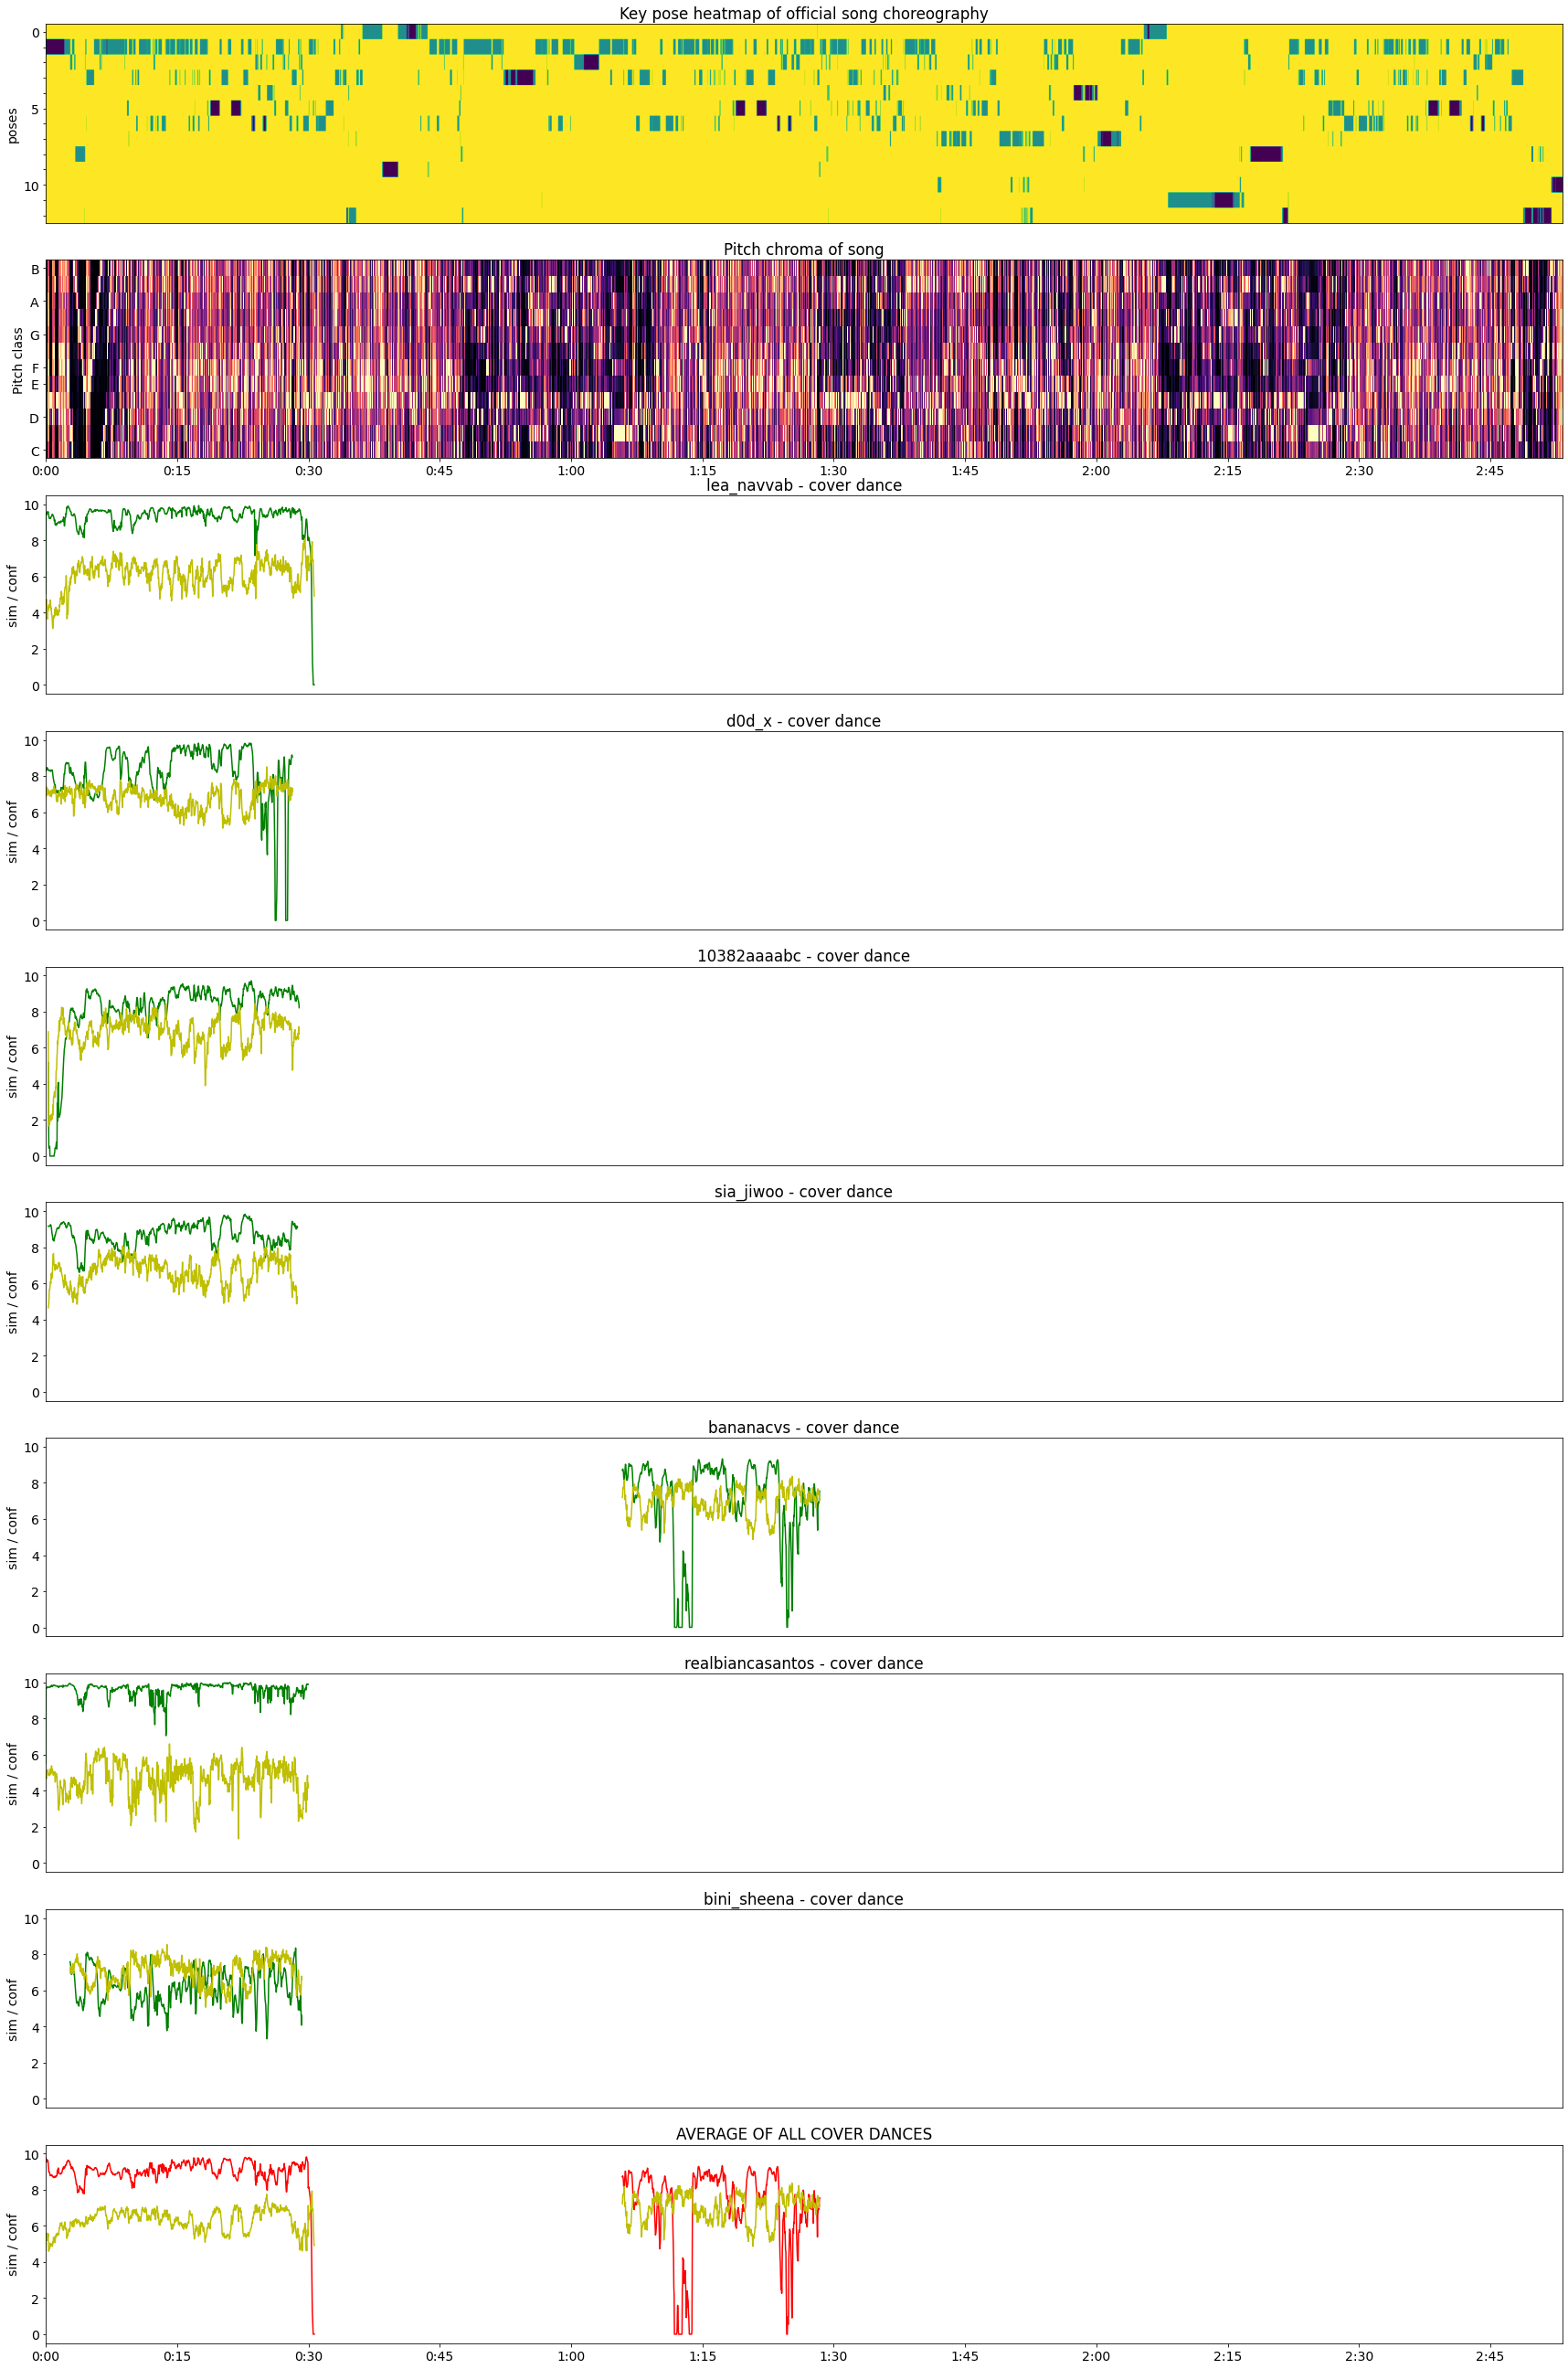

In [ ]:
reference_time_keys = list(sorted_reference_by_time.keys())

font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

def clip_and_normalize_in_range(value, min, max):
    if value > max:
        return 1
    if value < min:
        return 0

    span = max - min
    return (value - min) / span

all_match_scores = []

# These are the normalized and interpolated versions of the per-video match scores in
# user_video_match_scores
video_match_scores = {}

max_match = 0
min_match = 1
for video_name in user_video_match_scores:
    for match_time in user_video_match_scores[video_name]:
        match_value = user_video_match_scores[video_name][match_time]
        if match_value > max_match:
            max_match = match_value
        if match_value < min_match:
            min_match = match_value
        all_match_scores.append(match_value)
mean_match = np.mean(all_match_scores)
std_match = np.std(all_match_scores)
print("MEAN MATCH",mean_match,"STD",std_match)
max_score = min(max_match, mean_match + (std_match*4))
min_score = max(min_match, mean_match - (std_match*4))
print("MAX MATCH",max_score,"MIN MATCH",min_score)

first_user_axis = 2 # Index of first row in output corresponding to a cover video

fig, ax = plt.subplots(nrows=len(user_video_match_scores.keys())+first_user_axis, figsize=(24,36))

fig.tight_layout(pad=1.0)

# Draw the key poses heatmap for the demonstration choreography
cell_height = 25
heatmap = np.zeros((len(label_keys)*cell_height, len(cluster_labels)), dtype=int)

for l, label in enumerate(cluster_labels):
    if label >= 0:
        label_index = label_keys.index(label)
        for r in range(cell_height):
            heatmap[(label_index*cell_height)+r,l] += 2
    else:
        closest_label = filled_cluster_labels[l]
        label_index = label_keys.index(closest_label)
        for r in range(cell_height):
            heatmap[(label_index*cell_height)+r,l] += 1

ax[0].imshow(heatmap, cmap='viridis_r')
ax[0].set_yticks(np.arange(cell_height/2, (len(label_keys)*cell_height)+cell_height/2, cell_height))
ax[0].set_yticklabels(np.arange(len(label_keys)))
ax[0].set(ylabel="poses")

ax[0].set_aspect('auto')
ax[0].get_xaxis().set_visible(False)

for ticklabel in ax[0].yaxis.get_ticklabels():
    if int(ticklabel.get_text()) % 5 != 0:
        ticklabel.set_visible(False)

ax[0].set_xlabel('')
ax[0].set_title('Key pose heatmap of official song choreography')

y, fs = get_audio_timeseries(f"{tiktok_folder}/{reference_base}.mp3")
duration = librosa.get_duration(y)
print("DURATION", duration)

# This adds a margin on either side of the plot that I can't get rid of
# librosa.display.waveshow(y, sr=fs, ax=ax[1], x_axis="time")
#S = librosa.feature.melspectrogram(y, sr=fs, n_mels=128, fmax=8000)
#S_dB = librosa.power_to_db(S, ref=np.max)
#librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=8000, ax=ax[1])

chroma, _, _, _ = get_chroma_features(f"{tiktok_folder}/{reference_base}.mp3", hop_length=hop_length)
librosa.display.specshow(chroma, ax=ax[1], y_axis='chroma', x_axis='time', hop_length=hop_length)
xticks = range(0, int(duration), 15)

ax[1].set_xticks(xticks)
ax[1].set_xlabel('')
ax[1].set_title('Pitch chroma of song')
#ax[1].set_title('Audio spectrogram of song')

# A time slot will be True if any cover has a pose at that time code
nonnan_mask_all_covers = np.full(len(reference_time_keys), False)
print("Length of non-NAN mask:", nonnan_mask_all_covers.shape)

for video_index, video_name in enumerate(user_video_match_scores):

    if video_name == "AVERAGE OF ALL COVERS":
        # This one needs to be treated separately
        continue

    video_matches = np.empty(len(reference_time_keys))
    video_matches[:] = np.nan

    for match_index in user_video_match_scores[video_name]:
        match_value = user_video_match_scores[video_name][match_index]
        normalized_value = clip_and_normalize_in_range(match_value, min_score, max_score)
        video_matches[match_index] = normalized_value * 10

    nans = np.isnan(video_matches)
    nonnan_indices = np.argwhere(~nans)
    first_nonnan = min(nonnan_indices)[0]
    last_nonnan = max(nonnan_indices)[0]
    video_matches[nans]= np.interp(np.array(reference_time_keys)[nans], np.array(reference_time_keys)[~nans], np.array(video_matches)[~nans])
    video_matches[:first_nonnan] = np.nan
    video_matches[last_nonnan+1:] = np.nan

    video_confidences = np.empty(len(reference_time_keys))
    video_confidences[:] = np.nan
    for frame_index in user_video_pose_confidences[video_name]:
        video_confidences[frame_index] = user_video_pose_confidences[video_name][frame_index] * 10

    video_confidences[nans] = np.interp(np.array(reference_time_keys)[nans], np.array(reference_time_keys)[~nans], np.array(video_confidences)[~nans])
    video_confidences[:first_nonnan] = np.nan
    video_confidences[last_nonnan+1:] = np.nan

    nonnan_mask_all_covers[first_nonnan:last_nonnan+1] = True

    ax[video_index+first_user_axis].sharey(ax[2])
    ax[video_index+first_user_axis].sharex(ax[1])

    print("PLOTTING COVER VIDEO",video_name)
    ax[video_index+first_user_axis].plot(reference_time_keys, video_matches, 'g-')
    ax[video_index+first_user_axis].plot(reference_time_keys, video_confidences, 'y-')
    ax[video_index+first_user_axis].get_xaxis().set_visible(False)
    ax[video_index+first_user_axis].set(title=video_name + " - cover dance")

    ax[video_index+first_user_axis].set(ylabel="sim / conf")

    video_match_scores[video_name] = video_matches

if "AVERAGE OF ALL COVERS" in user_video_match_scores:
    video_name = "AVERAGE OF ALL COVERS"

    video_matches = np.empty(len(reference_time_keys))
    video_matches[:] = np.nan

    for match_index in user_video_match_scores[video_name]:
        match_value = user_video_match_scores[video_name][match_index]
        normalized_value = clip_and_normalize_in_range(match_value, min_score, max_score)
        video_matches[match_index] = normalized_value * 10

    nans = np.isnan(video_matches)
    video_matches[nans]= np.interp(np.array(reference_time_keys)[nans], np.array(reference_time_keys)[~nans], np.array(video_matches)[~nans])

    video_confidences = np.empty(len(reference_time_keys))
    video_confidences[:] = np.nan
    for frame_index in user_video_pose_confidences[video_name]:
        video_confidences[frame_index] = user_video_pose_confidences[video_name][frame_index] * 10

    video_confidences[nans] = np.interp(np.array(reference_time_keys)[nans], np.array(reference_time_keys)[~nans], np.array(video_confidences)[~nans])

    for index, value in enumerate(list(nonnan_mask_all_covers)):
        if value == False:
            video_matches[index] = np.nan
            video_confidences[index] = np.nan

    ax[video_index+first_user_axis].sharey(ax[2])
    ax[video_index+first_user_axis].sharex(ax[1])

    ax[video_index+first_user_axis].plot(reference_time_keys, video_matches, 'r-')
    ax[video_index+first_user_axis].plot(reference_time_keys, video_confidences, 'y-')

    ax[video_index+first_user_axis].set(title="AVERAGE OF ALL COVER DANCES")

    ax[video_index+first_user_axis].set(ylabel="sim / conf")

    video_match_scores[video_name] = video_matches


plt.show()

fig.savefig(f"{tiktok_folder}/{plot_name}")


In [ ]:
import math

avg_data = pickle.load(open(f"{tiktok_folder}/choreo_analysis/{Path(tiktok_folder).name}_AVERAGE_OF_COVERS.p", "rb"))

average_sticks_folder = Path(f"{tiktok_folder}/average_stickfigures")
average_sticks_folder.mkdir(parents=True, exist_ok=True)

# For keeping track of the head center (nose) of each pose, in pixels of the output image,
# presumably ordered X,Y (for integration into EverybodyDanceNow_reproduce_pytorch workflow)
target_head_coords = []
average_head_coords = []

# Original keypoint indices are in KEYPOINT_DICT from movenet_detector
# If we call the neck point index 17, then the stick figure will have ellipses connecting
# the following points:
# XXX Except in OpenPose, the neck point is index 1, and the other indices are very different too.
# So we'll need to convert between them
connections = [
    [0, 1], # nose to left_eye 0 1
    [1, 3], # left_eye to left_ear 1 3
    [0, 2], # nose to right_eye 0 2
    [2, 4], # right_eye to right_ear 2 4
    [0, 17], # nose to neck 0 17
    [17, 5], # neck to left_shoulder 17 5
    [17, 6], # neck to right_shoulder 17 6
    [5, 7], # left_shoulder to left_elbow 5 7
    [6, 8], # rigt_shoulder to right_elbow 6 8
    [7, 9], # left_elbow to left_wrist 7 9
    [8, 10], # right_elbow to right_wrist 8 10
    [17, 11], # neck to left_hip 17 11
    [17, 12], # neck to right_hip 17 12
    [11, 13], # left_hip to left_knee 11 13
    [12, 14], # right_hip to right_knee 12 14
    [13, 15], # left_knee to left_ankle 13 15
    [14, 16] # right_knee to right_ankle 14 16
]

# OpenPose joints are: 0=nose, 1=neck, 2=Rshould, 3=Relbow, 4=Rwrist
# 5=Lshould, 6=Lelbow, 7=Lwrist, 8=Rhip, 9=Rknee, 10=Rankle, 11=Lhip,
# 12=Lknee, 13=Lankle, 14=Reye, 15=Leye, 16=Rear, 17=Lear

# This is the connection ordering used in the EverybodyDanceNow PyTorch port
# when plotting the stick figure poses for training and inference.
# We need to use the COCO joint indices however.
edn_connections = [
    [17, 6], # Neck to Right Shoulder
    [17, 5], # Neck to Left Shoulder
    [6, 8], # Right Shoulder to Right Elbow
    [8, 10], # Right Elbow to Right Wrist
    [5, 7], # Left Shoulder to Left Elbow,
    [7, 9], # Left Elbow to Left Wrist,
    [17, 12], # Neck to Right Hip
    [12, 14], # Right Hip to Right Knee
    [14, 16], # Right Knee to Right Ankle
    [17, 11], # Neck to Left Hip
    [11, 13], # Left Hip to Left Knee
    [13, 15], # Left Knee to Left Ankle
    [17, 0], # Neck to Nose
    [0, 2], # Nose to Right Eye
    [2, 4], # Right Eye to Right Ear
    [0, 1], # Nose to Left Eye
    [1, 3] # Left Eye to Left Ear
]

# XXX Creating new training data for pose2video model (target images)

# target_sticks_folder = Path(f"{tiktok_folder}/target_stickfigures")
# target_sticks_folder.mkdir(parents=True, exist_ok=True)

# img_height = 2160
# img_width = 3840

# shape_dst = min([img_height, img_width]) #2160

# oh = (img_height - shape_dst) // 2 # 0
# ow = (img_width - shape_dst) // 2 # 3840 - 2160 // 2 = 840
# #img = img[oh: 2160, ow: 3000]
# # then resize to 512, 512

# # IDEA: crop source image to 2648 x 2160 (w x h)

# print("oh", oh, "ow", ow)

# for reference_index in sorted_reference_by_time:
#     reference_frame = sorted_reference_by_time[reference_index]
#     reference_pose = normalize_pose(reference_frame)

min_y = 1280
max_y = 0
min_x = 1280
max_x = 0

denormed_coords_by_reference_index = {}

min_x_index = 0
max_x_index = 0
min_y_index = 0
max_y_index = 0

image_count = 0

for reference_index in avg_data['average_poses']:

    # XXX For the Zoom example only
    if reference_index > 1838:
        break

    # XXX Skip denorming for now to see what it looks like
    normed_coords = avg_data['average_poses'][reference_index]
    norms = avg_data['average_norms'][reference_index]
    #norms = [4000, 4000]
    denormalized_coords = normed_coords[:,:2] * norms
    #denormed_coords = normed_coords[:,:2] * norms
    # Need to add an 18th coordinate (index 17) that is between the two shoulder coords ("neck")
    neck_values = np.array([np.mean(denormalized_coords[5:7],axis=0)])
    denormed_coords_w_neck = np.append(denormalized_coords, neck_values, axis=0)
    denormed_coords = np.column_stack((denormed_coords_w_neck[:,1], denormed_coords_w_neck[:,0]))

    # if np.amin(denormed_coords, axis=0)[0] < min_x:
    #     print("min X so far:",np.amin(denormed_coords, axis=0)[0])
    #     min_x_index = reference_index
    # if np.amax(denormed_coords, axis=0)[0] > max_x:
    #     print("max X so far:",np.amax(denormed_coords, axis=0)[0])
    #     max_x_index = reference_index
    # if np.amin(denormed_coords, axis=0)[1] < min_y:
    #     print("min Y so far:",np.amin(denormed_coords, axis=0)[1])
    #     min_y_index = reference_index
    # if np.amax(denormed_coords, axis=0)[1] > max_y:
    #     print("max Y so far:",np.amax(denormed_coords, axis=0)[1])
    #     max_y_index = reference_index

    min_x = min(min_x, np.amin(denormed_coords, axis=0)[0])
    max_x = max(max_x, np.amax(denormed_coords, axis=0)[0])
    min_y = min(min_y, np.amin(denormed_coords, axis=0)[1])
    max_y = max(max_y, np.amax(denormed_coords, axis=0)[1])

    denormed_coords_by_reference_index[reference_index] = denormed_coords

print("MIN_X",min_x,"MAX_X",max_x,"MIN_Y",min_y,"MAX_Y",max_y)

min_x = max(0, np.amin(denormed_coords, axis=0)[0])
max_x = np.amax(denormed_coords, axis=0)[0]
min_y = max(0,np.amin(denormed_coords, axis=0)[1])
max_y = np.amax(denormed_coords, axis=0)[1]

print("MIN_X",min_x,"MAX_X",max_x,"MIN_Y",min_y,"MAX_Y",max_y)
#print("INDICES: MIN_X",min_x_index,"MAX_X",max_x_index,"MIN_Y",min_y_index,"MAX_Y",max_y_index)

# print("MIN_X COORDS")
# print(denormed_coords_by_reference_index[min_x_index])
# print("MAX_X COORDS")
# print(denormed_coords_by_reference_index[max_x_index])
# print("MIN_Y COORDS")
# print(denormed_coords_by_reference_index[min_y_index])
# print("MAX_Y COORDS")
# print(denormed_coords_by_reference_index[max_y_index])

# on both sides. Not really sure why this is needed, but it helps the figures to fit
#x_padding = 150
#y_padding = 20

# There's a better way to do this if we know the source video dimensions
x_margin = math.ceil(round(max_x/2) / 2.)*2
y_margin = math.ceil(round(max_y/2) / 2.)*2

min_dim = min(math.ceil(max_x / 2.)*2, math.ceil(max_y / 2.)*2)
min_margin = min(x_margin, y_margin)

# XXX Detections and plotting may have flipped Y axes... or maybe even flipped X axes
#shape = (round(max_y - min_y + 1), round(max_x - min_x + 1))
#shape = (round(max_y)+y_padding*2, round(max_x)+x_padding*2)
#shape = (math.ceil(max_y / 2.) * 2, math.ceil(max_x / 2.) * 2)
shape = (min_dim+min_margin, min_dim+min_margin)
print("image shape",shape,"margin",min_margin)

for reference_index in denormed_coords_by_reference_index:

    # XXX For the Zoom example only
    if reference_index > 1838:
        break

    label_img = np.zeros(shape, dtype=np.uint8)
    denormed_coords = denormed_coords_by_reference_index[reference_index]

    denormed_coords[:,0] += min_margin - 100
    #denormed_coords[:,1] += y_padding - y_margin
    denormed_coords[:,1] += min_margin - 250

    # This should be correct, i.e., giving the nose position in output image coordinates
    average_head_coords.append(denormed_coords[0][:2])

    for i, link in enumerate(edn_connections):
        #print("Coords for link", link, denormed_coords[link[0]], denormed_coords[link[1]])
        coords_center = tuple(np.round(np.mean(np.array([denormed_coords[link[1]], denormed_coords[link[0]]]), axis=0)).astype(int))
        #print("coords_center",coords_center)
        limb_dir = denormed_coords[link[1]] - denormed_coords[link[0]]
        #print("limb_dir",limb_dir)
        limb_length = np.linalg.norm(limb_dir)
        #print("limb_length",limb_length)
        angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))
        #print("angle",angle)

        polygon = cv2.ellipse2Poly(coords_center, (int(limb_length / 2), 4), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(label_img, polygon, i+1) # Model seems to want only very light fill
        #cv2.fillConvexPoly(label_img, polygon, i+50)

    image_count += 1

    #label_image_pil = PIL.Image.fromarray(label_img)
    #label_image_pil = label_image_pil.resize((512,512))
    #label_image_pil.save(f"{average_sticks_folder}/{str(image_count).zfill(5)}.png", "PNG")

    cv2.imwrite(f"{average_sticks_folder}/{str(image_count).zfill(5)}.png", label_img)


average_head_coords_arr = np.array(average_head_coords, dtype=int)
np.save(f"{tiktok_folder}/pose_source.npy", average_head_coords_arr)

            #joint_coords = joint_list[joint_indices, :2]
            #coords_center = tuple(np.round(np.mean(joint_coords, 0)).astype(int))
            #cord_list.append(joint_coords[0])
            #limb_dir = joint_coords[0, :] - joint_coords[1, :]
            #limb_length = np.linalg.norm(limb_dir)
            #angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))
            #polygon = cv2.ellipse2Poly(coords_center, (int(limb_length / 2), 4), int(angle), 0, 360, 1)
            #cv2.fillConvexPoly(label, polygon, limb_type+1)

MIN_X -9.535911 MAX_X 727.9779 MIN_Y -14.089033 MAX_Y 1280.6154
MIN_X 15.214982 MAX_X 689.19775 MIN_Y 0 MAX_Y 1268.1335
image shape (1036, 1036) margin 346


In [ ]:
FPS = 30
!ffmpeg -y -framerate 30 -pattern_type glob -i '../tiktok/Jessi-Zoom/average_stickfigures/*.png' -c:v libx264 -pix_fmt yuv420p ../tiktok/Jessi-Zoom/average_stickfigures.mp4
#!ffmpeg -y -i ../tiktok/Jessi-Zoom/average_stickfigures.mp4 -i ../tiktok/Jessi-Zoom/CHOYOUNG_Cover.mp3 -c:v copy -c:a aac ../tiktok/Jessi-Zoom/average_stickfigures_w_audio.mp4
!ffmpeg -y -i ../tiktok/Jessi-Zoom/average_stickfigures.mp4 -i ../tiktok/Jessi-Zoom/user_audio/sia_jiwoo.mp3 -c:v copy -c:a aac ../tiktok/Jessi-Zoom/average_stickfigures_w_audio.mp4

In [ ]:
FPS = 30
!ffmpeg -y -framerate 30 -pattern_type glob -i '../tiktok/Jessi-Zoom/aligned_poses/*.png' -c:v libx264 -pix_fmt yuv420p ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4
!ffmpeg -y -i ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4 -i ../tiktok/Jessi-Zoom/user_audio/sia_jiwoo.mp3 -c:v copy -c:a aac ../tiktok/Jessi-Zoom/sia_jiwoo_align_w_audio.mp4

TOTAL USER TIME KEYS: 855


/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5015653e-06
  1.2578721e-05  4.6423042e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  duration = librosa.get_duration(y)
/opt/homebrew/Caskroom/miniforge/base/envs/py39/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/var/folders/np/m014_5fx6531yh4jph5_d_pm0000gr/T/ipykernel_23891/956760967.py:38: FutureWarning: Pass y=[0.00950024 0.01682714 0.01327126 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  du

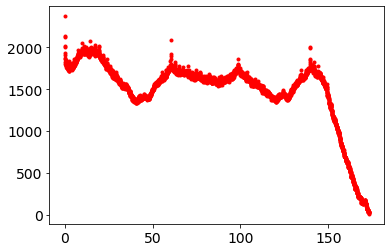

Best match starts at 0.2786394557823129s, index 6, value 2373.470703125, duration 28.5


In [ ]:
user_video_name = "sia_jiwoo"

user_capture = pickle.load(open(Path(f"{tiktok_folder}/user_video/{user_video_name}.p"), 'rb'))

user_poses_by_time = { frame['time']: frame for frame in user_capture }
sorted_poses_by_time = { k: user_poses_by_time[k] for k in sorted(user_poses_by_time) }

reference_time_keys = list(sorted_reference_by_time.keys())
user_time_keys = list(sorted_poses_by_time.keys())

print("TOTAL USER TIME KEYS:", len(user_time_keys))

#match_start, match_duration = align_pose_excerpt_to_full(reference_capture, user_capture, viz=True)

match_start, match_duration = align_audio_files(f"{tiktok_folder}/{reference_base}.mp3", f"{tiktok_folder}/user_audio/{user_video_name}.mp3", features="chroma", viz=True)

10380 0.2786394557823129 28.5
0.2836166517551708 28.778748486921742 17 1725
MIN SIM: 0.7914112901687622 MAX_SIM: 1.0072625374794006 SCALE FACTOR: 4.6328201131998465
USER VIDEO KEYS AND MATCHES: 855 855
AVERAGE POSES KEYS AND MATCHES: 1595 1595
MIN Y: 0.7790799371400373 MAX Y 0.9536717988680015
ref match times 855 user match values 855
avg match times 855 avg match values 855


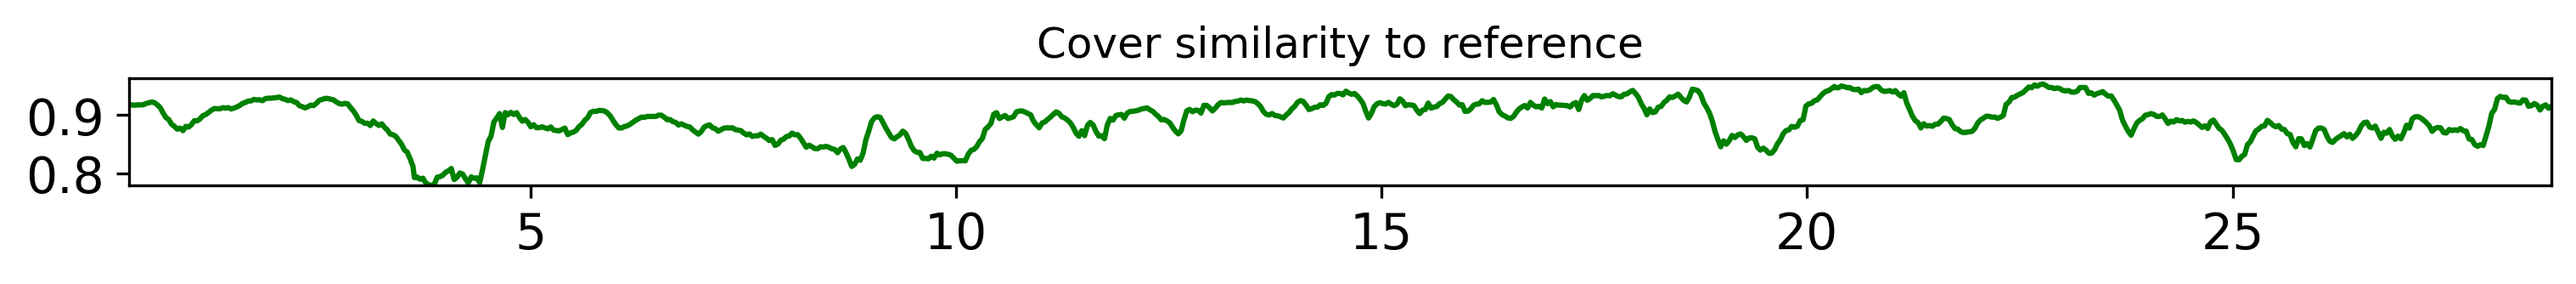

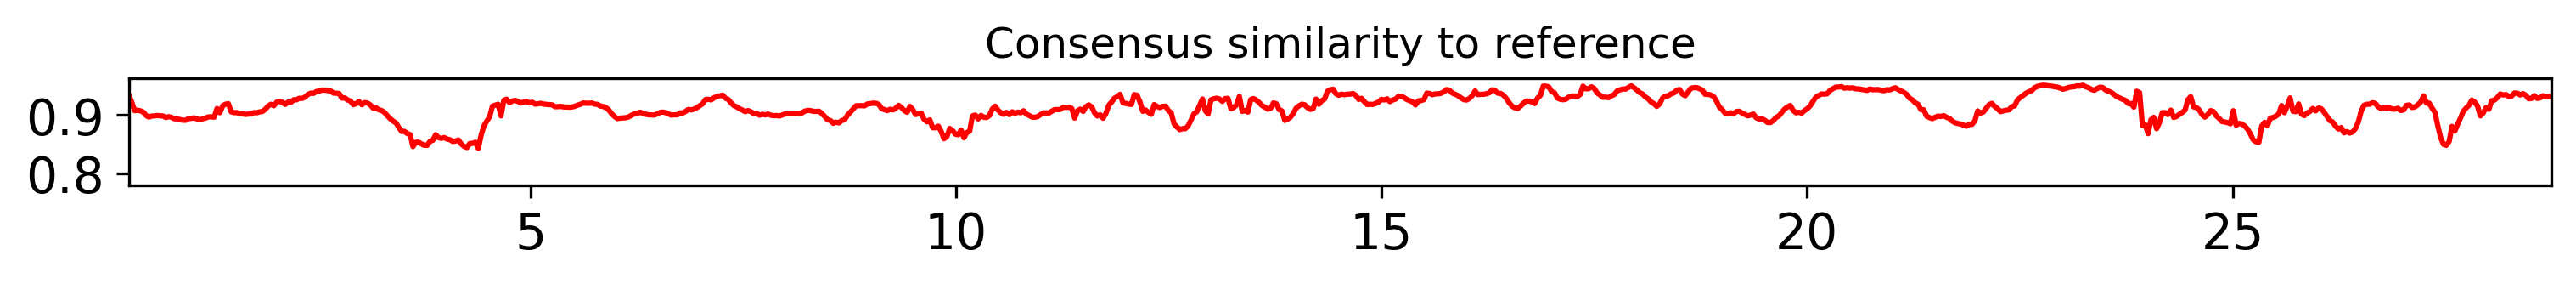

Processing reference time 0.2836166517551708 index 17 user index 0
Processing reference time 0.3169833166675438 index 19 user index 1
Processing reference time 0.35034998157991687 index 21 user index 2
Processing reference time 0.3837166464922899 index 23 user index 3
Processing reference time 0.4170833114046629 index 25 user index 4
Processing reference time 0.450449976317036 index 27 user index 5
Processing reference time 0.48381664122940904 index 29 user index 6
Processing reference time 0.5171833061417821 index 31 user index 7
Processing reference time 0.550549971054155 index 33 user index 8
Processing reference time 0.5839166359665281 index 35 user index 9
Processing reference time 0.6172833008789012 index 37 user index 10
Processing reference time 0.6506499657912742 index 39 user index 11
Processing reference time 0.6840166307036473 index 41 user index 12
Processing reference time 0.7173832956160202 index 43 user index 13
Processing reference time 0.7507499605283933 index 45 user

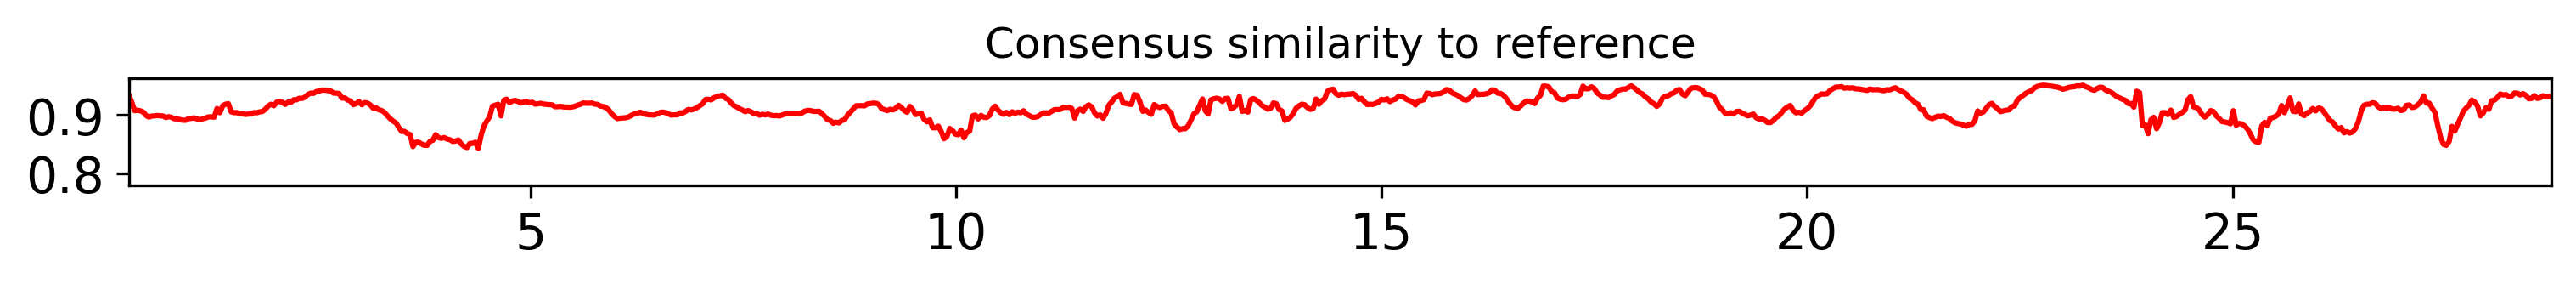

In [ ]:
### Code to visualize alignment of reference (instruction) video and a single TikTok cover video
#   as well as the average of all cover dances 
#   Also, potentially output image frames showing the denormalized stick figure of the average
#   pose to use with Everybody Dance now to generate a deepfake video of the reference dancer
#   doing the "consensus" dance

import tensorflow as tf
from datetime import timedelta

reference_match_start = find_closest(reference_time_keys, match_start)
reference_match_end = find_closest(reference_time_keys, match_start + match_duration)
reference_start_index = reference_time_keys.index(reference_match_start)
reference_end_index = reference_time_keys.index(reference_match_end)

print(len(reference_time_keys),  match_start, match_duration)
print(reference_match_start, reference_match_end, reference_start_index, reference_end_index)

aligned_poses_folder = Path(f"{tiktok_folder}/aligned_poses")
aligned_poses_folder.mkdir(parents=True, exist_ok=True)

max_sim = max(list(user_video_match_scores[user_video_name].values()) + list(user_video_match_scores['AVERAGE OF ALL COVERS'].values())) + .01
min_sim = min(list(user_video_match_scores[user_video_name].values()) + list(user_video_match_scores['AVERAGE OF ALL COVERS'].values())) + .01

sim_range = max_sim - min_sim
scale_factor = 1 / sim_range

print("MIN SIM:",min_sim, "MAX_SIM:", max_sim, "SCALE FACTOR:", scale_factor)

# user_video_match_scores should be indexed by reference index

print("USER VIDEO KEYS AND MATCHES:", len(user_video_match_scores[user_video_name].keys()), len(user_video_match_scores[user_video_name].values()))
print("AVERAGE POSES KEYS AND MATCHES:", len(user_video_match_scores['AVERAGE OF ALL COVERS'].keys()), len(user_video_match_scores['AVERAGE OF ALL COVERS'].values()))

# Just use the closest average times for plotting
avg_match_times = []
avg_match_values = []

reference_match_times = []
user_match_values = []
for ind in user_video_match_scores[user_video_name].keys():
    match_time = reference_time_keys[ind]
    reference_match_times.append(reference_time_keys[ind])
    user_match_values.append((user_video_match_scores[user_video_name][ind] - min_sim) * scale_factor)

    avg_match_ref = find_closest(list(user_video_match_scores['AVERAGE OF ALL COVERS'].keys()), ind)
    avg_match_time = reference_time_keys[avg_match_ref]

    avg_match_times.append(avg_match_time)
    avg_match_values.append((user_video_match_scores['AVERAGE OF ALL COVERS'][avg_match_ref] - min_sim) * scale_factor)

# for ref in range(reference_start_index, reference_end_index+1):
#     ref_time = reference_time_keys[ref]
#     if ref in user_video_match_scores['AVERAGE OF ALL COVERS']:
#         avg_match_times.append(reference_time_keys[ref])
#         avg_match_values.append((user_video_match_scores['AVERAGE OF ALL COVERS'][ref] - min_sim) * scale_factor)

max_y = max(user_match_values + avg_match_values)
min_y = min(user_match_values + avg_match_values)
print("MIN Y:", min_y, "MAX Y", max_y)

DPI = 300

print("ref match times",len(reference_match_times), "user match values", len(user_match_values))
print("avg match times",len(avg_match_times), "avg match values", len(avg_match_values))

# Note this assumes the reference match times is larger than avg match times
# common_plot_times = sorted(list(set(reference_match_times).intersection(avg_match_times)))
# print("COMMON PLOT TIMES:", len(common_plot_times))

# user_common_matches = []
# for ind in user_video_match_scores[user_video_name].keys():
#     time_key = reference_time_keys[ind]
#     if time_key in common_plot_times:
#         user_common_matches.append((user_video_match_scores[user_video_name][ind] - min_sim) * scale_factor)

# avg_common_matches = []
# for ref in range(reference_start_index, reference_end_index+1):
#     if ref in user_video_match_scores['AVERAGE OF ALL COVERS']:
#         time_key = reference_time_keys[ref]
#         if time_key in common_plot_times:
#             avg_common_matches.append((user_video_match_scores['AVERAGE OF ALL COVERS'][ref] - min_sim) * scale_factor)

# print("USER COMMON MATCHES:",len(user_common_matches))
# print("AVG COMMON MATCHES:", len(avg_common_matches))


user_sim_fig = plt.figure(figsize=(10,1), constrained_layout=True)
user_sim_fig.dpi=DPI
plt.margins(x=0)
plt.plot(reference_match_times, user_match_values, 'g-')
#plt.plot(common_plot_times, user_common_matches, 'g-')
ax = plt.gca()
ax.set_title("Cover similarity to reference", fontsize=12)
ax.set_ylim([min_y, max_y+.01])
plt.show()

avg_sim_fig = plt.figure(figsize=(10,1), constrained_layout=True)
avg_sim_fig.dpi=DPI
plt.margins(x=0)
plt.plot(avg_match_times, avg_match_values, 'r-')
#plt.plot(common_plot_times, avg_common_matches, 'r-')
ax = plt.gca()
ax.set_title("Consensus similarity to reference", fontsize=12)
ax.set_ylim([min_y, max_y+.01])
plt.show()

frame_count = 0

for user_match_time in user_time_keys:
    reference_time = user_match_time + match_start
    reference_match_time = find_closest(reference_time_keys[reference_start_index:reference_end_index+1], reference_time)
    reference_match_index = reference_time_keys.index(reference_match_time)

    user_frame = sorted_poses_by_time[user_match_time]
    reference_frame = sorted_reference_by_time[reference_match_time]
    user_frame_index = user_time_keys.index(user_match_time)

    # if merge_alternating_indices and reference_match_index % 2 == 0:
    #     print("skipping even-numbered reference index", reference_match_index)
    #     continue

    print("Processing reference time", reference_match_time, "index", reference_match_index, "user index", user_frame_index)

    user_pose_plot = teddy.visualize_detections(user_frame['figures'], normalized=True, return_plot_as_image=True)
    user_frame_image = PIL.Image.fromarray(user_pose_plot)

    reference_pose_plot = teddy.visualize_detections(reference_frame['figures'], normalized=True, return_plot_as_image=True)
    reference_frame_image = PIL.Image.fromarray(reference_pose_plot)

    # There should always be one of these, if they've been computed ahead of time (see below)
    if reference_match_index in average_cover_poses_by_reference_index:
        averaged_coords = average_cover_poses_by_reference_index[reference_match_index]
    elif merge_alternating_indices and reference_match_index+1 in average_cover_poses_by_reference_index:
        averaged_coords = average_cover_poses_by_reference_index[reference_match_index+1]
    else:
        print("Can't find a match in averaged poses for index", reference_match_index)
        continue

    # Note that these poses have already been normalized and symmetrified
    padded_coords = tf.expand_dims(tf.expand_dims(averaged_coords, axis=0), axis=0)
    averaged_pose_plot = teddy.__visualize_normalized_pose__(padded_coords, return_plot_as_image=True)
    averaged_frame_image = PIL.Image.fromarray(averaged_pose_plot)

    frame_count += 1

    combined_plots_width = user_frame_image.width + reference_frame_image.width + averaged_frame_image.width
    combined_plots_height = max([user_frame_image.height, reference_frame_image.height, averaged_frame_image.height])

    user_pose_image = PIL.Image.open(f"{tiktok_folder}/user_video/{user_video_name}/image{str(user_frame_index+1).zfill(5)}.png")

    reference_pose_image = PIL.Image.open(f"{tiktok_folder}/video_folder/image{str(reference_match_index+1).zfill(5)}.png")
    resized_reference_image = reference_pose_image.resize((combined_plots_width - user_pose_image.width, user_pose_image.height))

    plt.figure(user_sim_fig)
    user_sim_progress = plt.axvline(x=reference_match_time, color='b')
    user_sim_fig.canvas.draw()
    user_sim_image = PIL.Image.frombytes('RGB', user_sim_fig.canvas.get_width_height(), user_sim_fig.canvas.tostring_rgb())
    user_sim_progress.remove()
    resized_user_sim_image = user_sim_image.resize((combined_plots_width-512, int(combined_plots_width/10)))

    plt.figure(avg_sim_fig)
    avg_sim_progress = plt.axvline(x=reference_match_time, color='b')
    avg_sim_fig.canvas.draw()
    avg_sim_image = PIL.Image.frombytes('RGB', avg_sim_fig.canvas.get_width_height(), avg_sim_fig.canvas.tostring_rgb())
    avg_sim_progress.remove()
    resized_avg_sim_image = avg_sim_image.resize((combined_plots_width-512, int(combined_plots_width/10)))

    combined_image_height = combined_plots_height + user_pose_image.height + max(resized_user_sim_image.height + resized_avg_sim_image.height, 512)

    combined_image = PIL.Image.new('RGB', (combined_plots_width, combined_image_height))
    combined_image.paste(reference_frame_image, (0,0))
    combined_image.paste(user_frame_image, (reference_frame_image.width,0))
    combined_image.paste(averaged_frame_image, (reference_frame_image.width+user_frame_image.width,0))
    combined_image.paste(resized_reference_image, (0, combined_plots_height))
    combined_image.paste(user_pose_image, (resized_reference_image.width, combined_plots_height))
    combined_image.paste(resized_user_sim_image, (0, combined_plots_height + resized_reference_image.height))
    combined_image.paste(resized_avg_sim_image, (0, combined_plots_height + resized_reference_image.height + resized_user_sim_image.height))

    # Deepfake images should always be 512x512
    if os.path.exists(f"{tiktok_folder}/consensus_deepfake/{str(frame_count+1).zfill(5)}_synthesized_image.jpg"):
        deepfake_image = PIL.Image.open(f"{tiktok_folder}/consensus_deepfake/{str(frame_count+1).zfill(5)}_synthesized_image.jpg")
        combined_image.paste(deepfake_image, (combined_plots_width-512, combined_plots_height + resized_reference_image.height))

    draw = ImageDraw.Draw(combined_image)
    font_path = os.path.join(cv2.__path__[0],'qt','fonts','Arial.ttf')
    font = PIL.ImageFont.truetype(font_path, size=64)

    draw.text((10, 10),"Reference",(0,0,0),font=font)
    if reference_match_index in user_video_match_scores[user_video_name]:
        draw.text((user_frame_image.width+10, 10),f"Cover\nsim to ref: {((user_video_match_scores[user_video_name][reference_match_index] - min_sim) * scale_factor):.2f}",(0,0,0),font=font)
    else:
        print("No match score available for cover video at ref match index",reference_match_index)
        # XXX Hack to deal with reference and cover video frame indices that get out of sync
        # due to differing frame rates (where one is 2x the other)
        draw.text((user_frame_image.width+10, 10),f"Cover\nsim to ref: {((user_video_match_scores[user_video_name][reference_match_index-1] - min_sim) * scale_factor):.2f}",(0,0,0),font=font)
    if reference_match_index in user_video_match_scores['AVERAGE OF ALL COVERS']:
        draw.text((user_frame_image.width+reference_frame_image.width+10, 10),f"Consensus\nsim to ref: {((user_video_match_scores['AVERAGE OF ALL COVERS'][reference_match_index] - min_sim) * scale_factor):.2f}",(0,0,0),font=font)
    else:
        print("No match score available for average at ref match index",reference_match_index)
    draw.text((10, combined_plots_height+10),"Reference",(0,0,0),font=font)
    draw.text((resized_reference_image.width+10, combined_plots_height+10),"Cover",(0,0,0),font=font)
    draw.text((combined_plots_width-512+10, combined_plots_height + resized_reference_image.height+10),"Consensus",(0,0,0), font=font)

    # Need to add 1 to the zero-based reference match index so it will align with the frame IDs
    # from detect_video
    combined_image.save(aligned_poses_folder / Path(f"{str(reference_match_index+1).zfill(5)}_{reference_base}_{user_video_name}_{str(user_frame_index+1).zfill(5)}.png"), 'PNG')

In [ ]:
FPS = 30
!ffmpeg -y -framerate 30 -pattern_type glob -i '../tiktok/Jessi-Zoom/aligned_poses/*.png' -c:v libx264 -pix_fmt yuv420p ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4
!ffmpeg -y -i ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4 -i ../tiktok/Jessi-Zoom/user_audio/sia_jiwoo.mp3 -c:v copy -c:a aac ../tiktok/Jessi-Zoom/sia_jiwoo_align_w_audio.mp4

ffmpeg version 5.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox -

In [ ]:
# Idea: combine all similarity time series into a single megadance
#       do the same for confidence time series
#       and motion time series
#       XXX These must all be exactly the same length. sim and conf should be already,
#       but DOUBLE CHECK that motion is the same length as the others!
# Calculate correlation of similarity:confidence and similarity:motion
# similarity:motion resuts might not be meaningful if time scales are not normalized (e.g., to 1/6th of a second)
#
# Also: resample all covers into 100 time slices, plot meand and stdev of similarity to reference
#       (could also plot these re: similarity to avg/consensus)

import scipy.stats as stats

# For each cover video data file -- probably need to skip AVERAGE files --
#       redistribute reference similarity, confidence, motion data into 100 time buckets
#       (should be OK to assume that the original time indices are evenly spaced
def extract_and_resample_choreo_data(choreo_data_path, samples=100, viz=False):
    choreo_data = pickle.load(open(choreo_data_path, "rb"))

    resampled_choreo_data = {'sim_to_reference': [], 'pose_confidence': [], 'motion': []}

    sim_values = [choreo_data['sim_to_reference'][k] for k in sorted(choreo_data['sim_to_reference'])] 
    conf_values = [choreo_data['pose_confidence'][k] for k in sorted(choreo_data['pose_confidence'])]
    motion_values = [choreo_data['motion'][k] for k in sorted(choreo_data['motion'])]
    motion_values = [0] + motion_values

    choreo_values = {'sim_to_reference': sim_values, 'pose_confidence': conf_values, 'motion': motion_values}

    step_size = len(sim_values) / 100
    s=0
    while s < len(sim_values) and len(resampled_choreo_data['sim_to_reference']) < 100:
        i = round(s)
        j = round(s + step_size)
        window_size = j - i
        resampled_choreo_data['sim_to_reference'].append(sum(sim_values[i:j])/window_size)
        s += step_size

    step_size = len(conf_values) / 100
    s = 0
    while s < len(conf_values) and len(resampled_choreo_data['pose_confidence']) < 100:
        i = round(s)
        j = round(s + step_size)
        window_size = j - i
        resampled_choreo_data['pose_confidence'].append(sum(conf_values[i:j])/window_size)
        s += step_size    

    step_size = len(motion_values) / 100
    s = 0
    while s < len(motion_values) and len(resampled_choreo_data['motion']) < 100:
        i = round(s)
        j = round(s + step_size)
        window_size = j - i
        resampled_choreo_data['motion'].append(sum(motion_values[i:j])/window_size)
        s += step_size   

    #print(len(sim_values), sim_window_size, len(conf_values), conf_window_size, len(motion_values), motion_window_size)
    # for key in resampled_choreo_data:
    #     print(key, len(resampled_choreo_data[key]))

    if viz:

        plt.plot(resampled_choreo_data['sim_to_reference'], "r-")
        plt.plot(resampled_choreo_data['pose_confidence'], "y-")
        plt.plot(resampled_choreo_data['motion'], "b-")

        plt.show()

    return choreo_values, resampled_choreo_data

all_sims = []
all_confs = []
all_motion = []

all_resampled_sims = []
all_resampled_confs = []
all_resampled_motion = []

for choreo_data_path in list(Path("../tiktok/combined_choreo_data/").glob("*.p")):
    if str(choreo_data_path).find("AVERAGE_OF_COVERS") != -1:
        continue

    print(choreo_data_path)

    choreo_data = pickle.load(open(choreo_data_path, 'rb'))

    choreo_values, resampled_choreo_data = extract_and_resample_choreo_data(choreo_data_path, viz=False)

    # for key in choreo_values:
    #     print(key, len(choreo_values[key]))

    # Check that they're the same length first, maybe pad or cut otherwise
    all_sims.extend(choreo_values['sim_to_reference'])
    all_confs.extend(choreo_values['pose_confidence'])
    all_motion.extend(choreo_values['motion'])

    #print(len(all_sims), len(all_confs), len(all_motion))

    all_resampled_sims.append(resampled_choreo_data['sim_to_reference'])
    all_resampled_confs.append(resampled_choreo_data['pose_confidence'])
    all_resampled_motion.append(resampled_choreo_data['motion'])

    #print(len(all_resampled_sims), len(all_resampled_confs), len(all_resampled_motion))

print(len(all_sims), len(all_confs), len(all_motion))

sim_motion_pearsonr, sim_motion_pearsonp = stats.pearsonr(all_motion, all_sims)
print("Pearson's r correlation between motion and similarity:",sim_motion_pearsonr, "p:", sim_motion_pearsonp)

# Don't expect this to be significant/meaningful because confidence is based on the still images
conf_motion_pearsonr, conf_motion_pearsonp = stats.pearsonr(all_motion, all_confs)
print("Pearson's r correlation between motion and confidence:",conf_motion_pearsonr, "p:", conf_motion_pearsonp)

# Don't expect this to be significant/meaningful because confidence is based on the still images
sim_conf_pearsonr, sim_conf_pearsonp = stats.pearsonr(all_sims, all_confs)
print("Pearson's r correlation between similarity and confidence:",sim_conf_pearsonr, "p:", sim_conf_pearsonp)

all_resampled_sims_by_slice = np.array(all_resampled_sims).T.tolist()

resampled_sim_means = []
resampled_sim_stdevs = []
resampled_sim_stdevs_lower = []
resampled_sim_stdevs_upper = []

for slice in all_resampled_sims_by_slice:
    mean = statistics.mean(slice)
    resampled_sim_means.append(mean)
    stdev = statistics.stdev(slice)
    resampled_sim_stdevs.append(stdev)
    resampled_sim_stdevs_lower.append(mean - stdev)
    resampled_sim_stdevs_upper.append(mean + stdev)

fig = plt.figure(figsize=(12,6), constrained_layout=True)
DPI = 100
fig.dpi=DPI
plt.margins(x=0)
for cover_sims in all_resampled_sims:
    plt.plot(range(0,100), cover_sims, label="_nolegend_", color="r", linestyle=':', alpha=0.2)
plt.plot(range(0,100), resampled_sim_means, label="mean similarity", color="r", linestyle="-")
#plt.plot(range(0,100), resampled_sim_stdevs_upper, label="mean + stdev", color="g", linestyle=':')
plt.plot(range(0,100), resampled_sim_stdevs_lower, label="mean - stdev", color="g", linestyle='--')
ax = plt.gca()
ax.legend()
ax.set_xlabel('time slice')
ax.set_ylabel('cosine similarity')
plt.show()
fig.savefig("../tiktok/combined_similarities.png", format='png', bbox_inches='tight', dpi=DPI)


In [ ]:
# Interpolation code -- not currently used
pose_capture = teddy.detect_video("../tiktok/user_video/lejonnytran.mp4", write_images=False, images_too=True)
interpolated_capture = interpolate_missing_poses(pose_capture, threshold=.2)
trimmed_capture = trim_empty_frames_start_end(interpolated_capture)
pickle.dump(trimmed_capture, open("../tiktok/pose_data/lejonnytran_w_images.p", "wb"))

In [ ]:
user_video_name = "10382aaaabc"
user_capture = pickle.load(open(f"{tiktok_folder}/user_video/{user_video_name}.p", "rb"))

NORMS: [1202.2102  950.7917]
NORMED POSE EXTENT: [0.38429213 0.4028953  0.8868663 ]
DENORMED POSE EXTENT: [461.9999 383.0695]
NORMS: [1475.4781 1148.5686]
NORMED POSE EXTENT: [0.42334074 0.34936982 0.8869424 ]
DENORMED POSE EXTENT: [624.63   401.2752]
NORMS: [1517.9811 1132.2281]
NORMED POSE EXTENT: [0.40565926 0.3737929  0.912038  ]
DENORMED POSE EXTENT: [615.7831  423.21884]
AVG NORMS: [1517.9811 1148.5686]
AVG POSE EXTENT: [0.3970873  0.34327507 0.7910474 ]
DENORMED AVG POSE EXTENT: [602.771   394.27496]


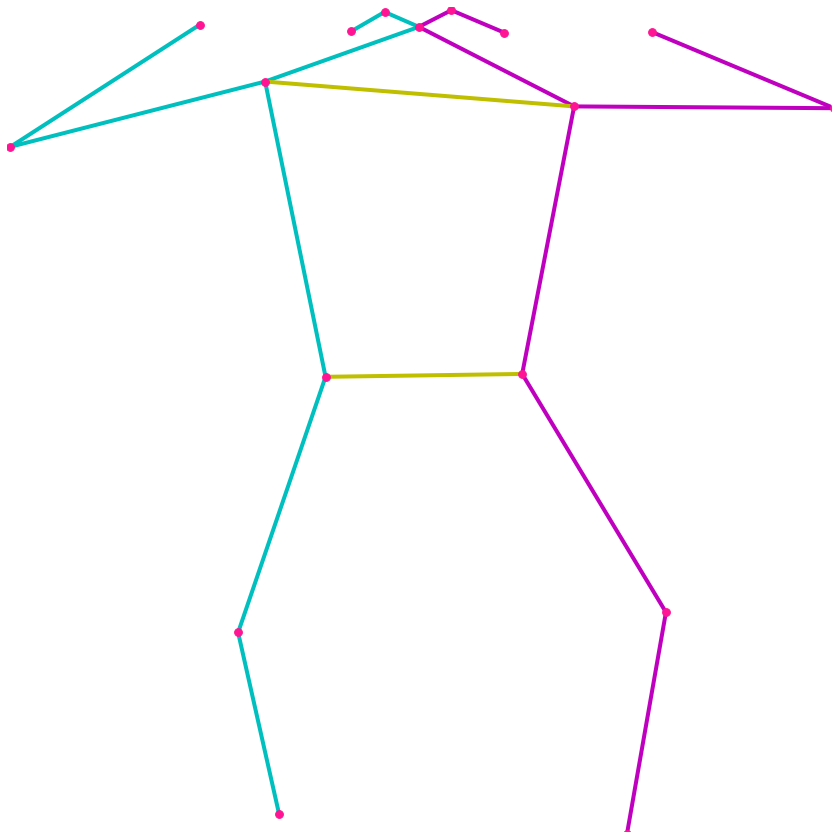

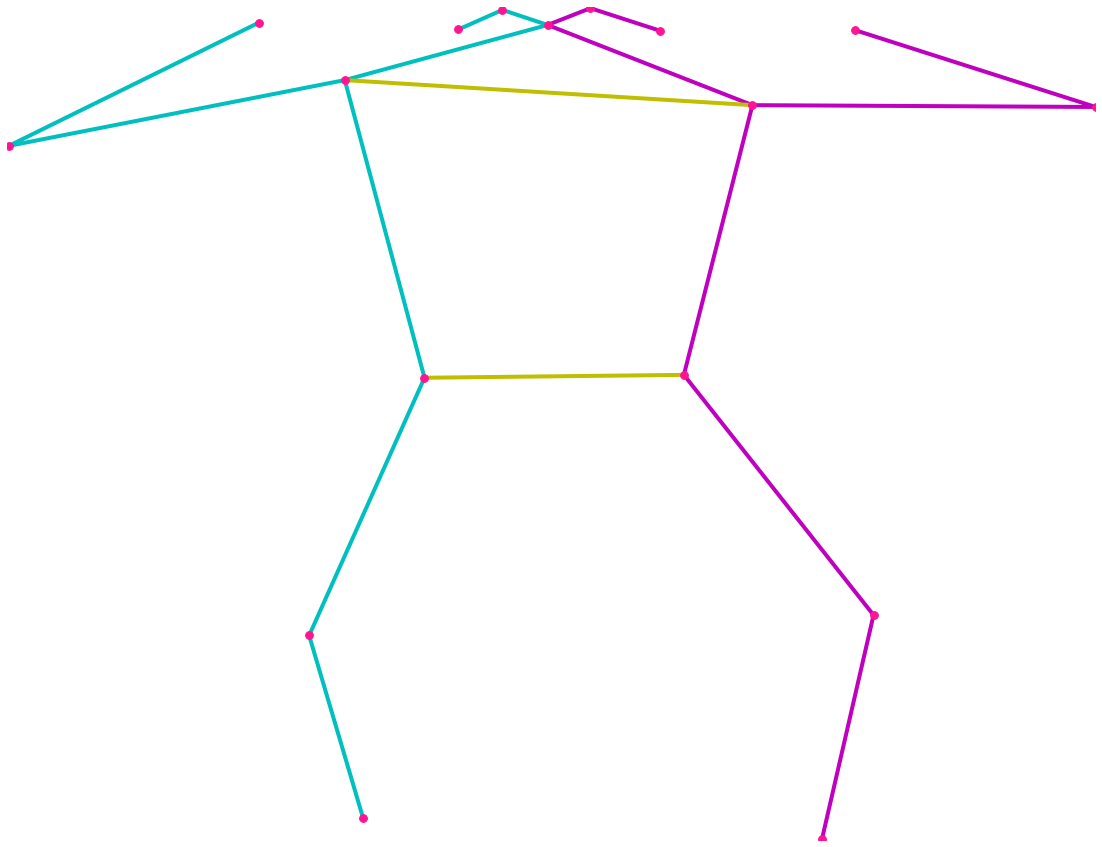

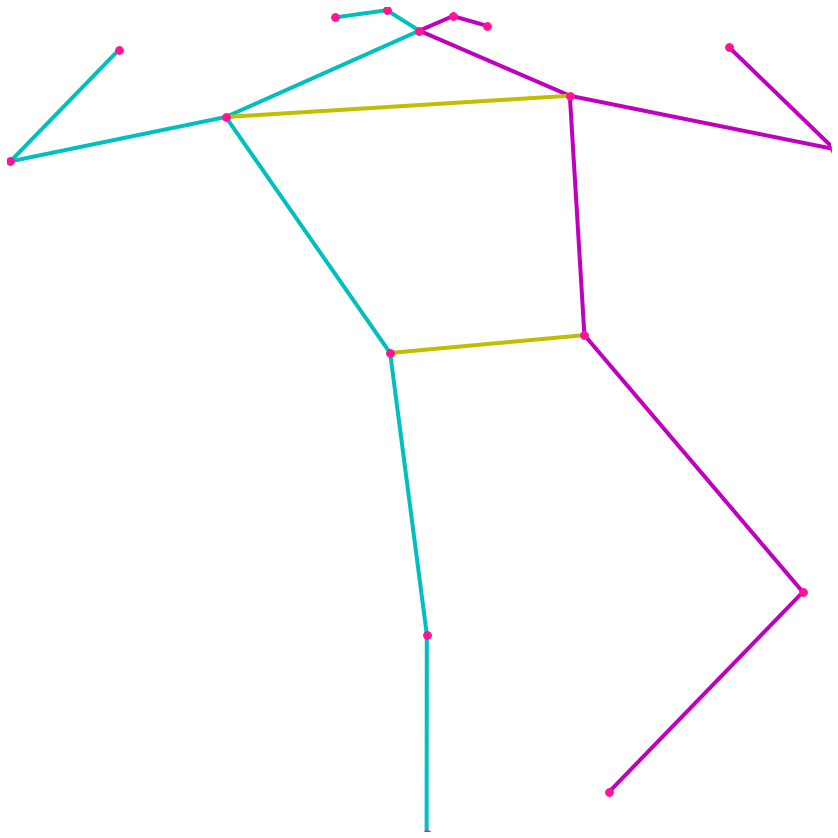

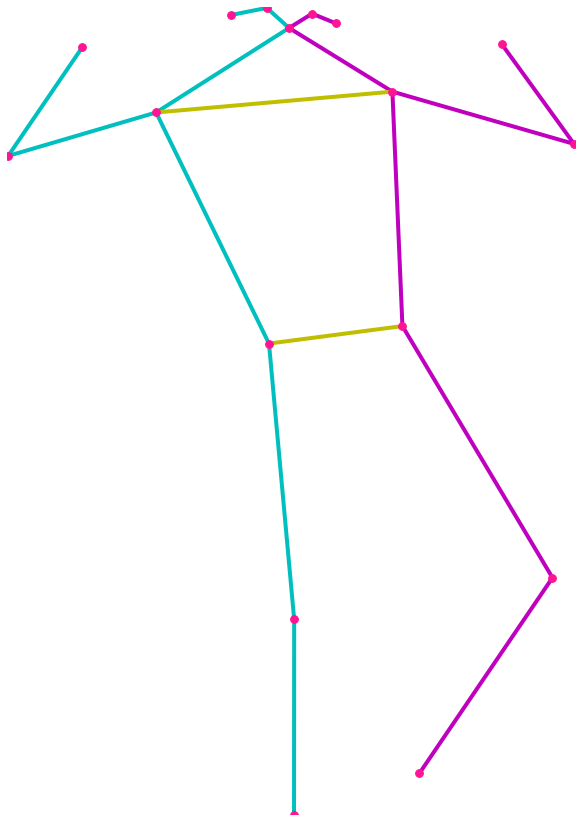

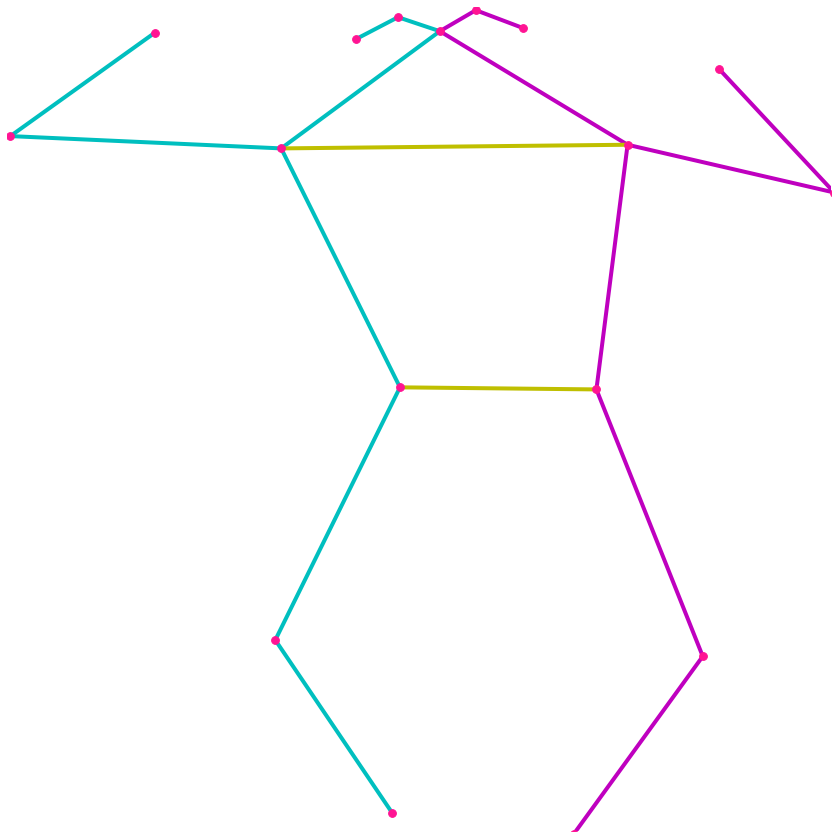

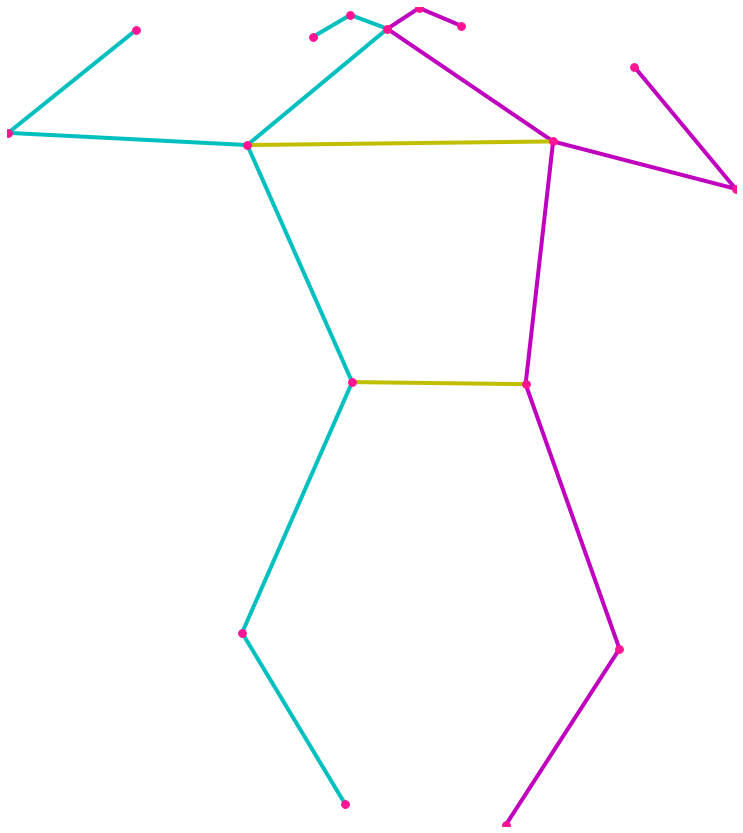

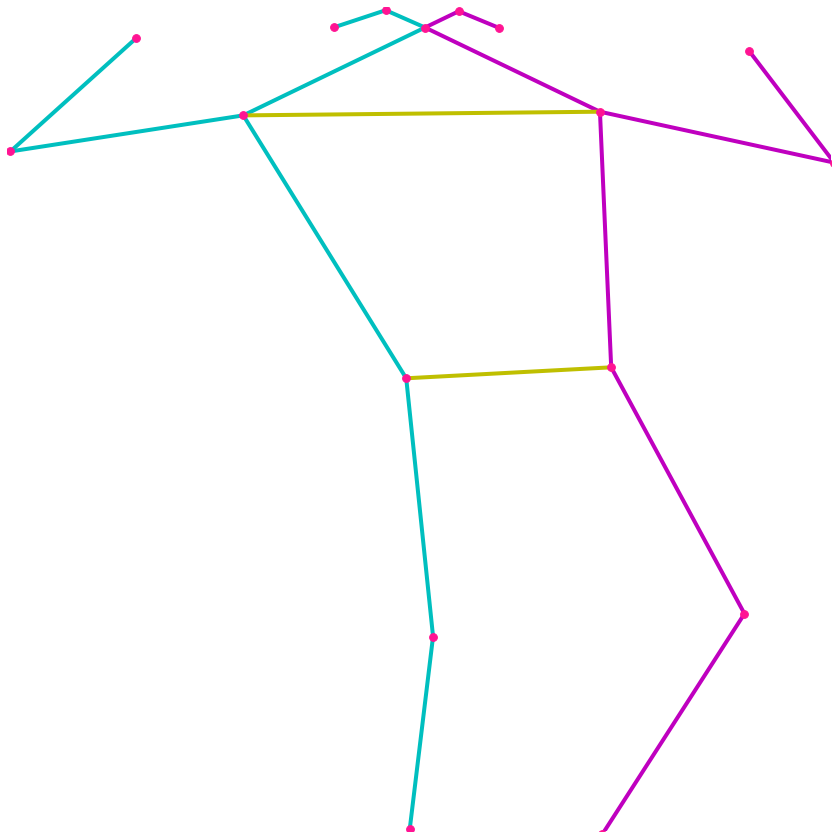

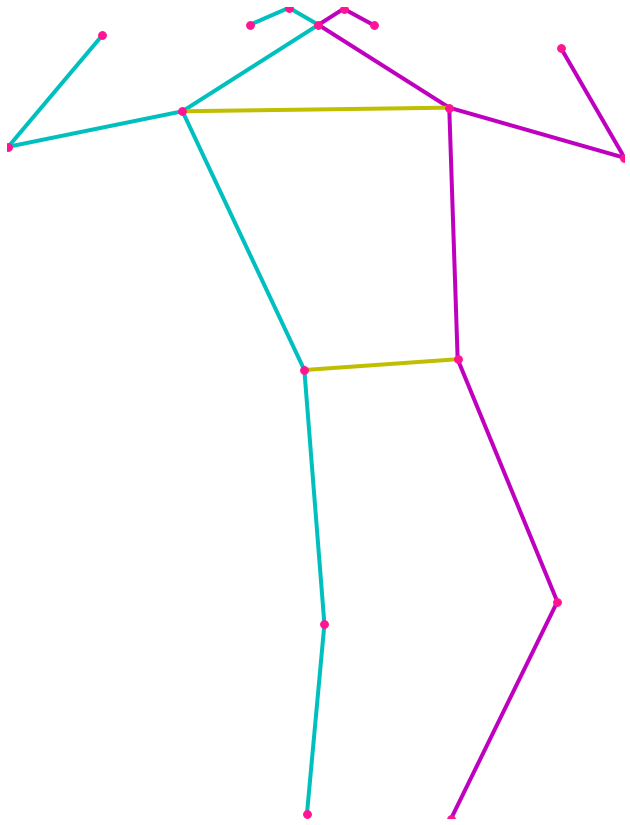

In [ ]:
import tensorflow as tf

reference_index = 600

#print(all_poses_by_reference_index[reference_index][0])

for i in range(len(all_poses_by_reference_index[reference_index])):
    print("NORMS:", all_norms_by_reference_index[reference_index][i])
    print("NORMED POSE EXTENT:", np.max(all_poses_by_reference_index[reference_index][i], axis=0))
    padded_coords = tf.expand_dims(tf.expand_dims(all_poses_by_reference_index[reference_index][i], axis=0), axis=0)
    teddy.__visualize_normalized_pose__(padded_coords)
    denormalized_coords = np.copy(all_poses_by_reference_index[reference_index][i])
    denormed_coords = all_poses_by_reference_index[reference_index][i][:,:2] * all_norms_by_reference_index[reference_index][i]
    denormalized_coords[:,:2] = denormed_coords[:,:2]
    print("DENORMED POSE EXTENT:", np.max(denormed_coords, axis=0))
    #print(denormalized_coords)
    padded_coords = tf.expand_dims(tf.expand_dims(denormalized_coords, axis=0), axis=0)
    teddy.__visualize_pose__(padded_coords)
#user_norm_factors = np.sqrt(sum(user_x**2))
#print(user_norm_factors)

norms = all_norms_by_reference_index[reference_index]
avg_norms = np.max(norms, axis=0)

print("AVG NORMS:", avg_norms)
averaged_pose = average_cover_poses_by_reference_index[reference_index]
print("AVG POSE EXTENT:", np.max(averaged_pose, axis=0))
padded_coords = tf.expand_dims(tf.expand_dims(averaged_pose, axis=0), axis=0)
teddy.__visualize_normalized_pose__(padded_coords)
denormalized_coords = np.copy(averaged_pose)
denormed_coords = denormalized_coords[:,:2] * avg_norms
print("DENORMED AVG POSE EXTENT:", np.max(denormed_coords, axis=0))
denormalized_coords[:,:2] = denormed_coords[:,:2]
#print(denormalized_coords)
padded_coords = tf.expand_dims(tf.expand_dims(denormalized_coords, axis=0), axis=0)
teddy.__visualize_pose__(padded_coords)


# denormalized_coords = np.copy(all_poses_by_reference_index[reference_index][0])
# denormed_coords = all_poses_by_reference_index[reference_index][0][:,:2] * all_norms_by_reference_index[300][0]
# denormalized_coords[:,:2] = denormed_coords[:,:2]
# print(denormalized_coords)
# padded_coords = tf.expand_dims(tf.expand_dims(denormalized_coords, axis=0), axis=0)
# teddy.__visualize_pose__(padded_coords)


In [ ]:
import tensorflow as tf
import copy

print(user_capture[300]['figures'][0].data)
teddy.visualize_detections(user_capture[300]['figures'])
ymin = np.min(user_capture[300]['figures'][0].data[:,0], axis=0)
xmin = np.min(user_capture[300]['figures'][0].data[:,1], axis=0)
print(xmin, ymin)
zeroified = copy.deepcopy(user_capture[300])
zeroified['figures'][0].data[:,0] -= ymin
zeroified['figures'][0].data[:,1] -= xmin
print(zeroified['figures'][0].data)
teddy.visualize_detections(zeroified['figures'])
normalized_coords = normalize_pose(zeroified)
print(normalized_coords)
padded_coords = tf.expand_dims(tf.expand_dims(normalized_coords, axis=0), axis=0)
teddy.__visualize_normalized_pose__(padded_coords)

user_x = zeroified['figures'][0].data[:,:2]
user_norm_factors = np.sqrt(sum(user_x**2))
print(user_norm_factors)
denormed_coords = normalized_coords[:,:2] * user_norm_factors
denormalized_coords = np.copy(normalized_coords)
denormalized_coords[:,:2] = denormed_coords[:,:2]
print(denormalized_coords)
padded_coords = tf.expand_dims(tf.expand_dims(denormalized_coords, axis=0), axis=0)
teddy.__visualize_pose__(padded_coords)

In [ ]:
FPS = 30
!ffmpeg -y -framerate 30 -pattern_type glob -i '../tiktok/Jessi-Zoom/aligned_poses/*.png' -c:v libx264 -pix_fmt yuv420p ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4
!ffmpeg -y -i ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4 -i ../tiktok/Jessi-Zoom/user_audio/sia_jiwoo.mp3 -c:v copy -c:a aac ../tiktok/Jessi-Zoom/sia_jiwoo_align_w_audio.mp4

In [ ]:
FPS = 30
!ffmpeg -y -framerate 30 -pattern_type glob -i '../tiktok/Jessi-Zoom/aligned_poses/*.png' -c:v libx264 -pix_fmt yuv420p ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4
!ffmpeg -y -i ../tiktok/Jessi-Zoom/sia_jiwoo_align.mp4 -i ../tiktok/Jessi-Zoom/user_audio/sia_jiwoo.mp3 -c:v copy -c:a aac ../tiktok/Jessi-Zoom/sia_jiwoo_align_w_audio.mp4